In [2]:
import pickle
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
from scipy import stats
from scipy.stats import poisson
from scipy.stats import norm
import pandas

In [3]:
# open the file of interest, and use pickle loading
signal_file = open ("Sample_pt_250_500.pkl",'rb')
sample_dict = pickle.load(signal_file)

# list all keys of the files
sample_dict.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

In [4]:
background_file = open ("qcd_100000_pt_250_500.pkl",'rb')
background_dict = pickle.load(background_file)

# list all keys of the files
background_dict.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

There are a total of 20100 events comprising of 100 higgs events and 20000 qcd events. So, we can weigh the data.

In [5]:
n_higgs_norm = 100/20100
n_qcd_norm = 20000/20100

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

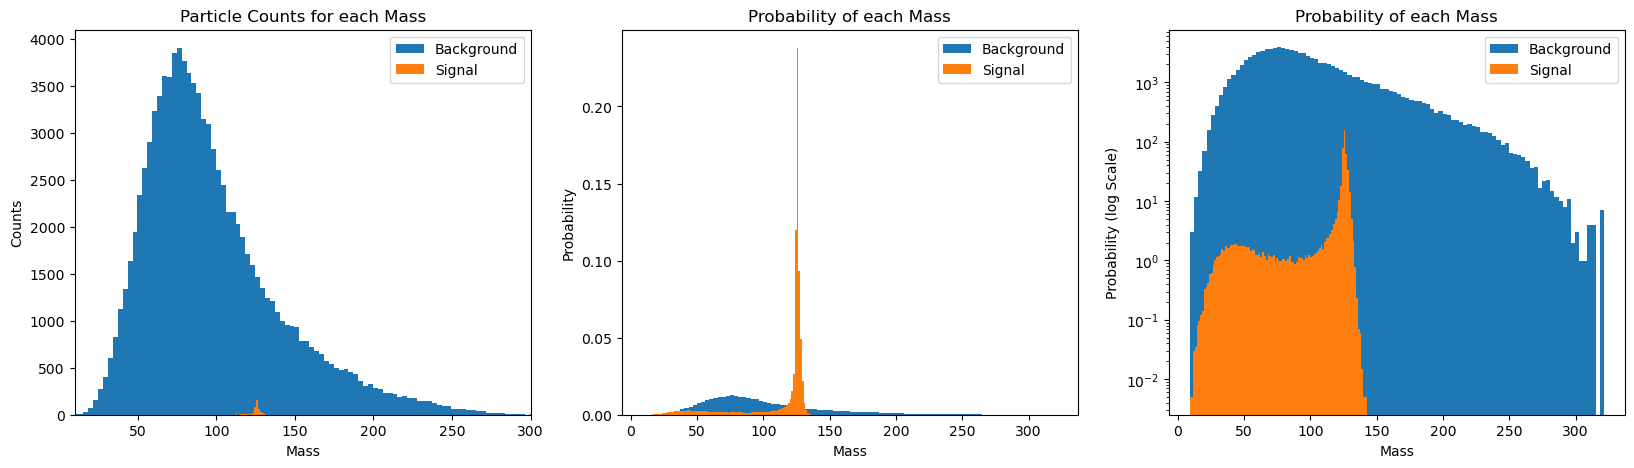

In [6]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
n_higgs_counts,bins1 = np.histogram(sample_dict['mass'],bins = 100)
n_qcd_counts,bins2 = np.histogram(background_dict['mass'],bins = 100)

ax[0].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,label="Background")
ax[0].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,label="Signal")
ax[0].set_xlim([10,300])
ax[0].set_title('Particle Counts for each Mass')
ax[0].set_xlabel('Mass')
ax[0].set_ylabel('Counts')
ax[0].legend(loc='best')

ax[1].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,density=True,label="Background")
ax[1].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,density=True,label="Signal")
ax[1].legend(loc='best')
ax[1].set_title('Probability of each Mass')
ax[1].set_xlabel('Mass')
ax[1].set_ylabel('Probability')

ax[2].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,label="Background")
ax[2].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,label="Signal")
ax[2].set_yscale('log')
ax[2].legend(loc='best')
ax[2].set_title('Probability of each Mass')
ax[2].set_xlabel('Mass')
ax[2].set_ylabel('Probability (log Scale)')

plt.show()

In [7]:
n_higgs_counts,bins1 = np.histogram(sample_dict['mass'],bins = 100)
len(n_higgs_counts)

100

In [8]:
np.mean(sample_dict['mass'])

114.89238664552165

The plot above shows the whole data set with the higgs data shown at ~115. 

Now I will calculate the significance.

In [9]:
n_higgs = 100
n_qcd = 20000
sigma = poisson.cdf(n_higgs + n_qcd,n_qcd)
probability = norm.isf(1-sigma)
probability

0.7112259282313185

In [10]:
sigma

0.7615278780931256

Now let's see how this approximation compares to the data.

In [11]:
approx = n_higgs/np.sqrt(n_qcd)
approx

0.7071067811865475

not equivalent, but pretty close. Although in particle physics, this approximation  is not good enough. This approximation is a gaussian statistic and gives us a good idea about what the probability value is. 

Now, I will make some mass cuts to find the the best significance

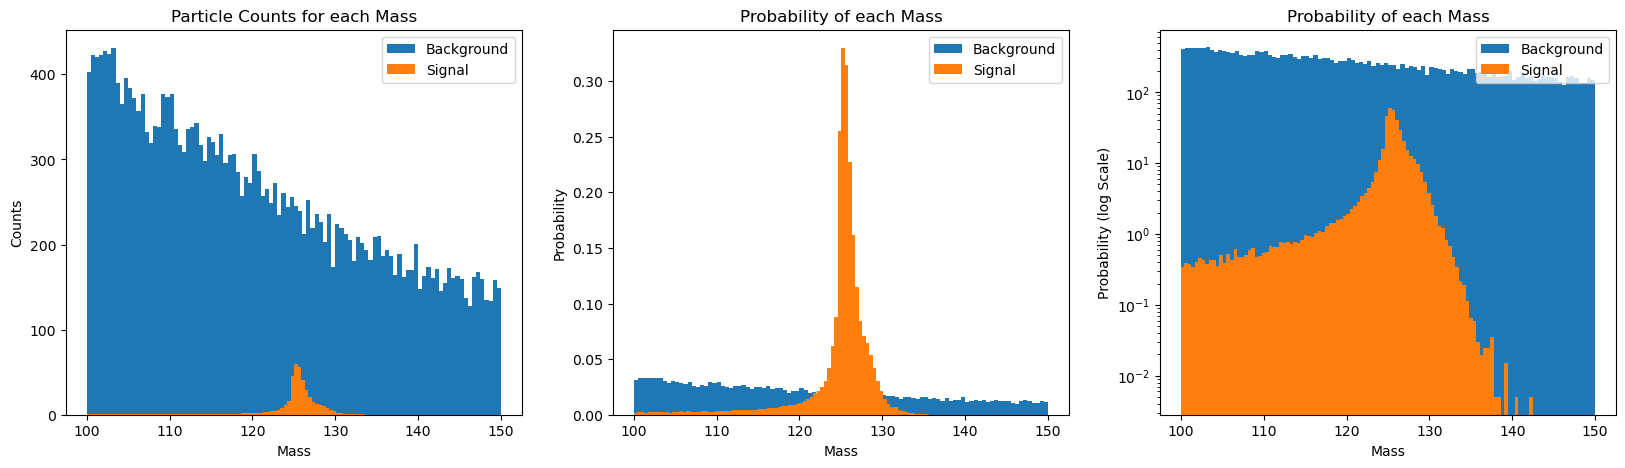

In [12]:
n_higgs_norm = 100/20100
n_qcd_norm = 20000/20100
def cut(sample_data,background_data,higgs_low_bound,higgs_high_bound,bkd_low_bound,bkd_high_bound,feature):
    cut_mass_higgs = sample_data[sample_data[feature]>higgs_low_bound]
    cut_mass_qcd = background_data[background_data[feature]>bkd_low_bound]
    
    cut_mass_higgs = cut_mass_higgs[cut_mass_higgs[feature]<higgs_high_bound]
    cut_mass_qcd = cut_mass_qcd[cut_mass_qcd[feature]<bkd_high_bound]
    
    fig,ax = plt.subplots(1,3,figsize=(20,5))
    n_higgs_counts,bins1 = np.histogram(cut_mass_higgs[feature],bins = 100)
    n_qcd_counts,bins2 = np.histogram(cut_mass_qcd[feature],bins = 100)

    ax[0].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,label="Background")
    ax[0].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,label="Signal")
    ax[0].set_title('Particle Counts for each Mass')
    ax[0].set_xlabel('Mass')
    ax[0].set_ylabel('Counts')
    ax[0].legend(loc='best')

    ax[1].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,density=True,label="Background")
    ax[1].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,density=True,label="Signal")
    ax[1].legend(loc='best')
    ax[1].set_title('Probability of each Mass')
    ax[1].set_xlabel('Mass')
    ax[1].set_ylabel('Probability')

    ax[2].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,label="Background")
    ax[2].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,label="Signal")
    ax[2].set_yscale('log')
    ax[2].legend(loc='best')
    ax[2].set_title('Probability of each Mass')
    ax[2].set_xlabel('Mass')
    ax[2].set_ylabel('Probability (log Scale)')

    plt.show()
    return cut_mass_higgs, cut_mass_qcd

cut_mass_higgs, cut_mass_qcd = cut(sample_dict,background_dict,100,150,100,150,'mass')

In [13]:
def signif(cut_mass_higgs,cut_mass_qcd,feature):
    n_higgs = 100
    n_qcd = 20000
    higgs = (sum(cut_mass_higgs[feature]) / sum(sample_dict[feature])) * n_higgs
    qcd = (sum(cut_mass_qcd[feature]) / sum(background_dict[feature])) * n_qcd

    significance = higgs / np.sqrt(qcd)
    print(significance)
    

In [14]:
signif(cut_mass_higgs,cut_mass_qcd,'mass')

1.1556144516115936


Need to find cuts to increase this number

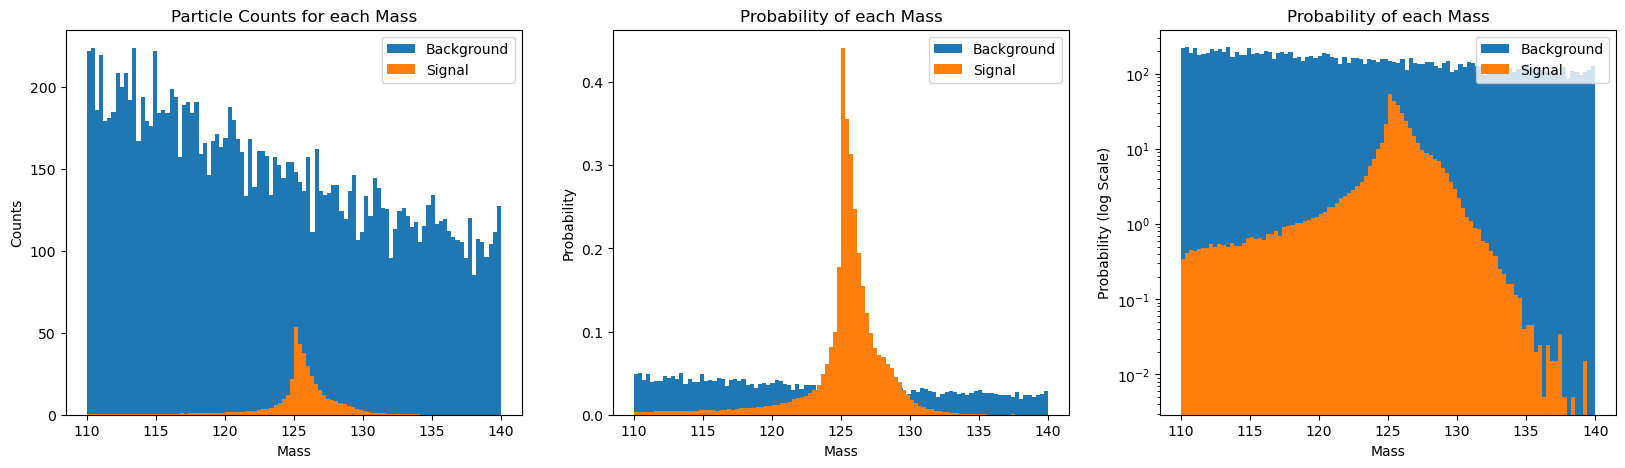

1.464999846258688


In [15]:
cut_mass_higgs, cut_mass_qcd = cut(sample_dict,background_dict,110,140,110,140,'mass')
signif(cut_mass_higgs,cut_mass_qcd,'mass')

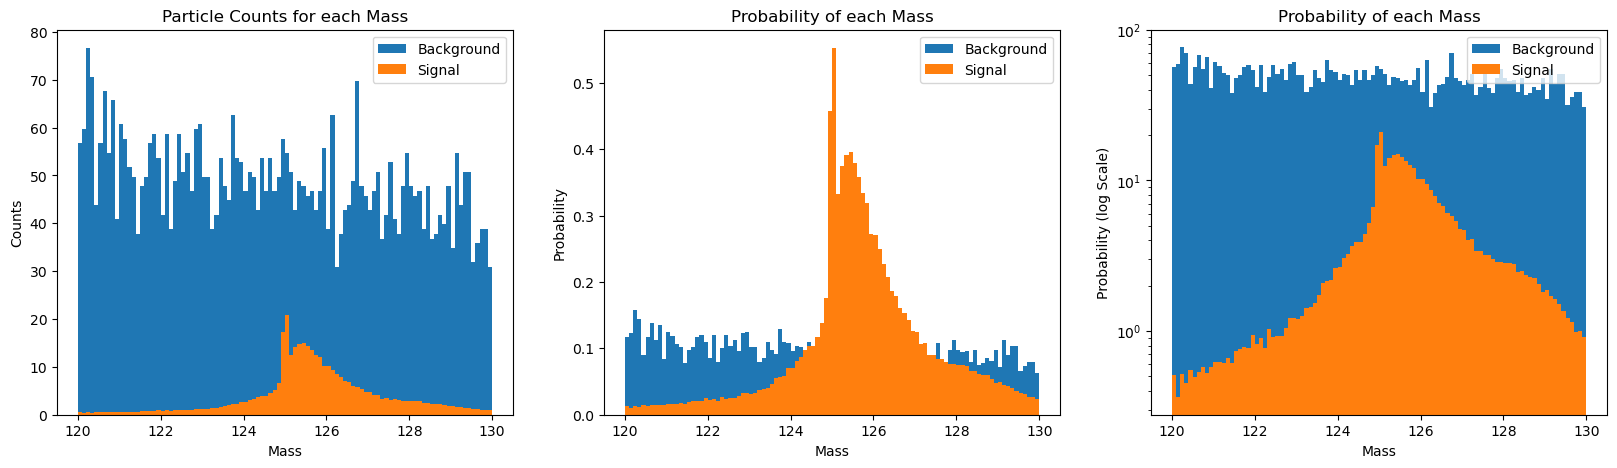

2.3470782626118902


In [16]:
cut_mass_higgs, cut_mass_qcd = cut(sample_dict,background_dict,120,130,120,130,'mass')
signif(cut_mass_higgs,cut_mass_qcd,'mass')

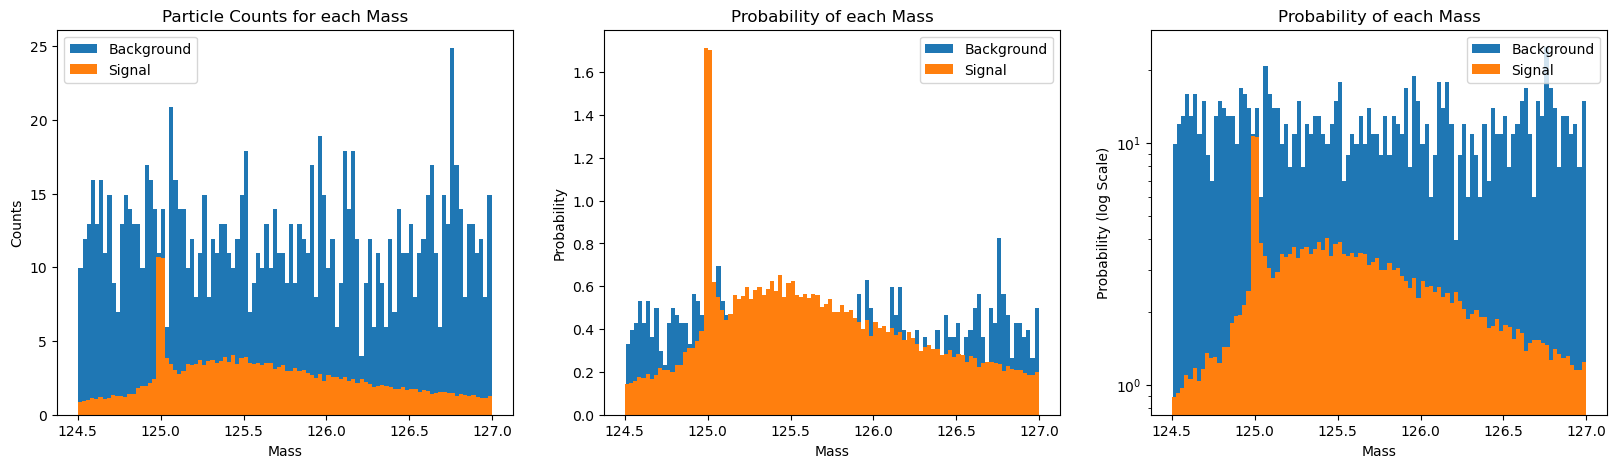

3.1007590939315057


In [17]:
cut_mass_higgs, cut_mass_qcd = cut(sample_dict,background_dict,124.5,127,124.5,127,'mass')
signif(cut_mass_higgs,cut_mass_qcd,'mass')

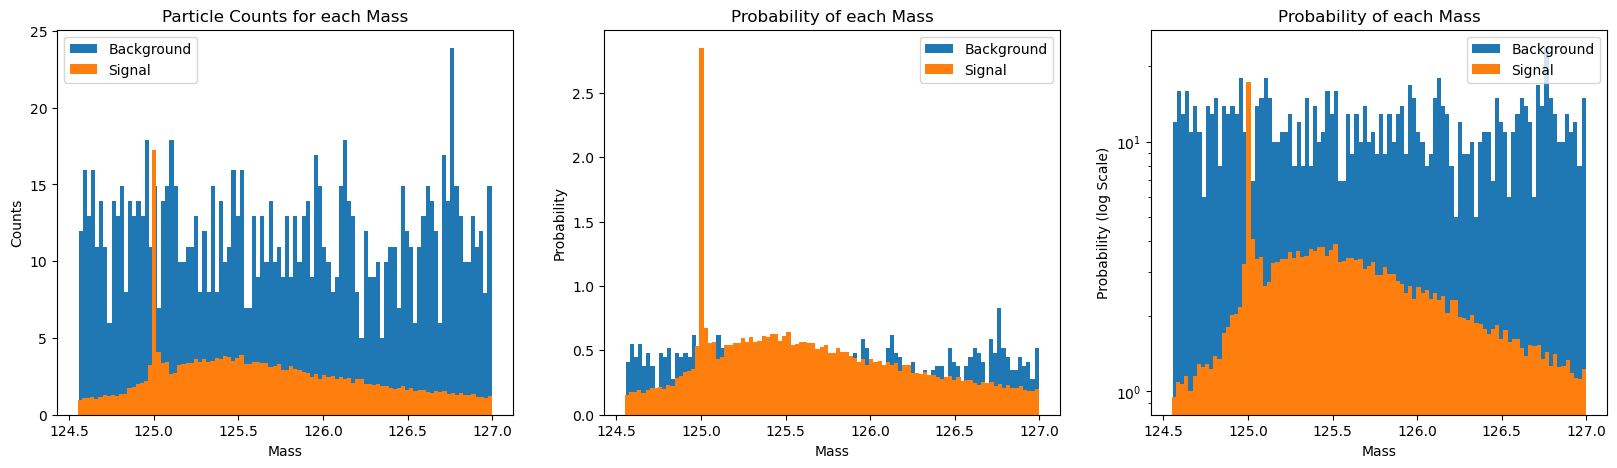

3.1065303151335293


In [18]:
cut_mass_higgs, cut_mass_qcd = cut(sample_dict,background_dict,124.55,127,124.55,127,'mass')
signif(cut_mass_higgs,cut_mass_qcd,'mass')

### Rest of Features

In [19]:
def hist(feature,sample_data,background_data):
    fig,ax = plt.subplots(1,3,figsize=(20,5))
    n_higgs_counts,bins1 = np.histogram(sample_data[feature],bins = 100)
    n_qcd_counts,bins2 = np.histogram(background_data[feature],bins = 100)

    ax[0].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm)
    ax[0].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm)
    ax[0].set_title(feature)
    ax[0].set_ylabel('Counts')

    ax[1].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,density=True)
    ax[1].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,density=True)
    ax[1].set_title(feature)
    ax[1].set_ylabel('Probability')

    ax[2].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm)
    ax[2].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm)
    ax[2].set_yscale('log')
    ax[2].set_title(feature)
    ax[2].set_ylabel('Probability (log scale)')

    plt.show()

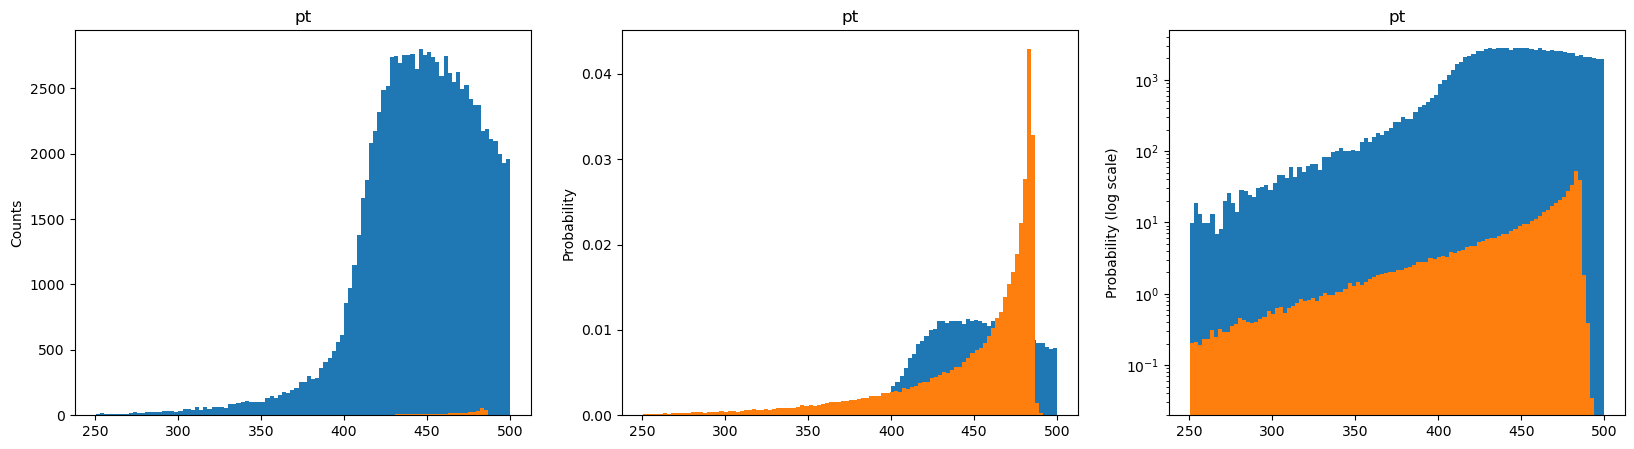

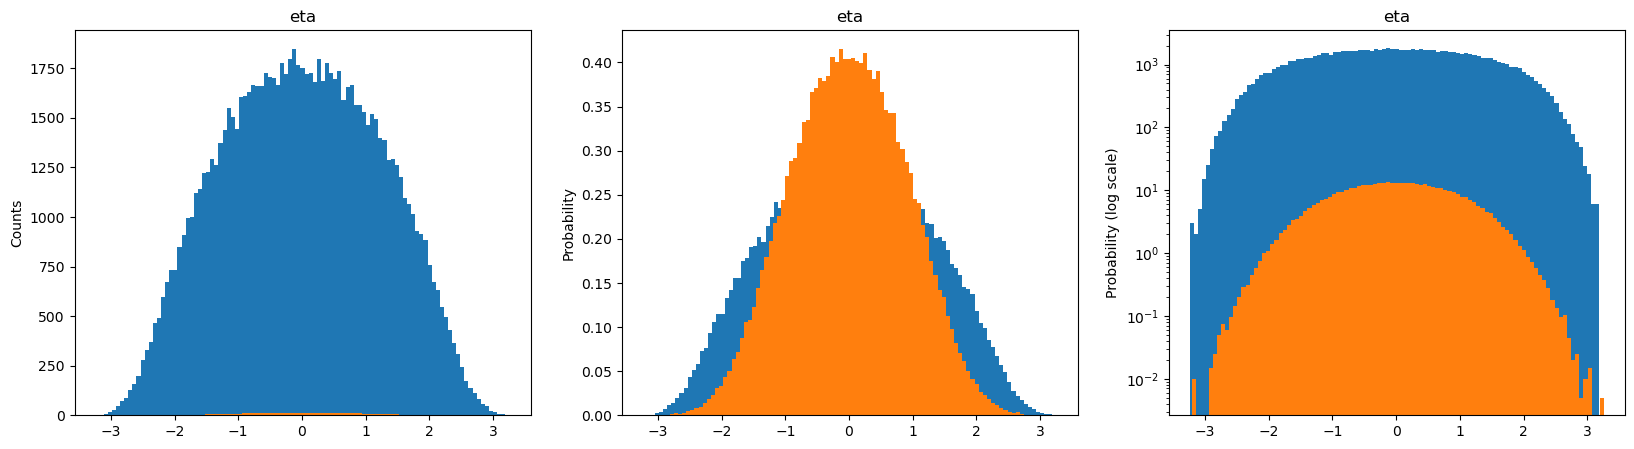

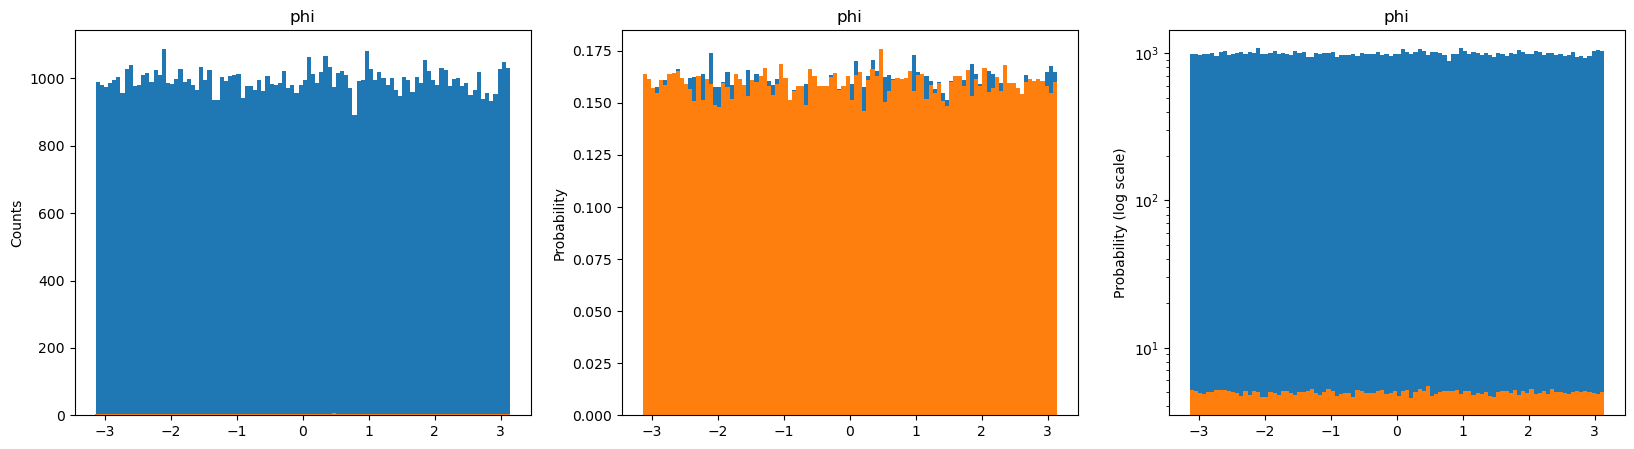

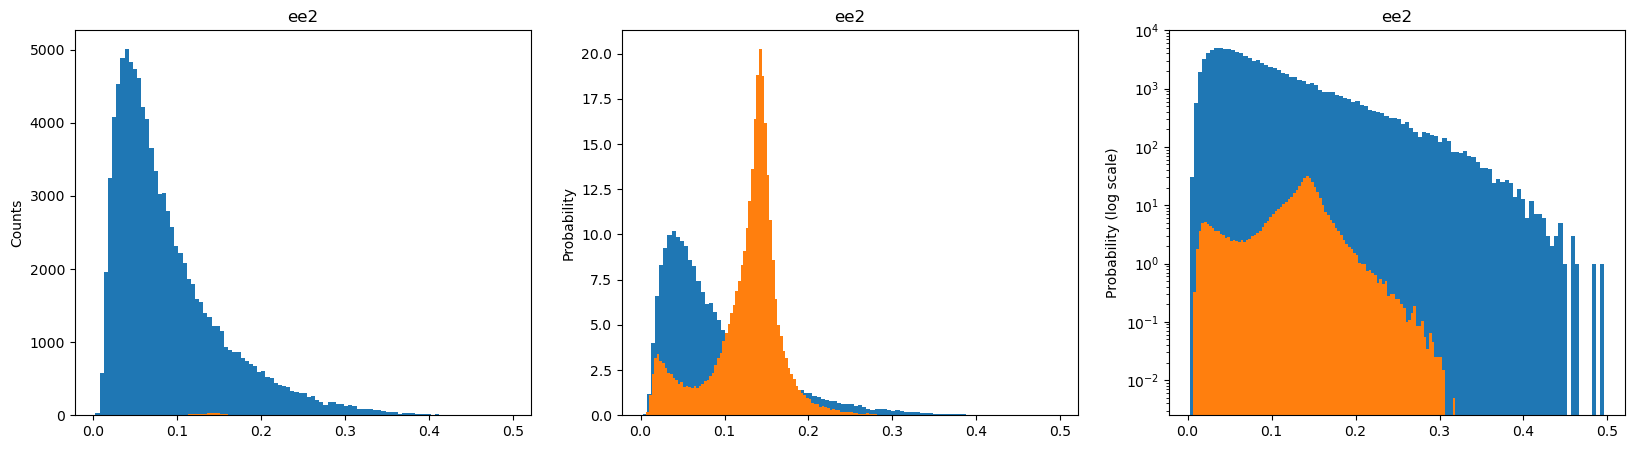

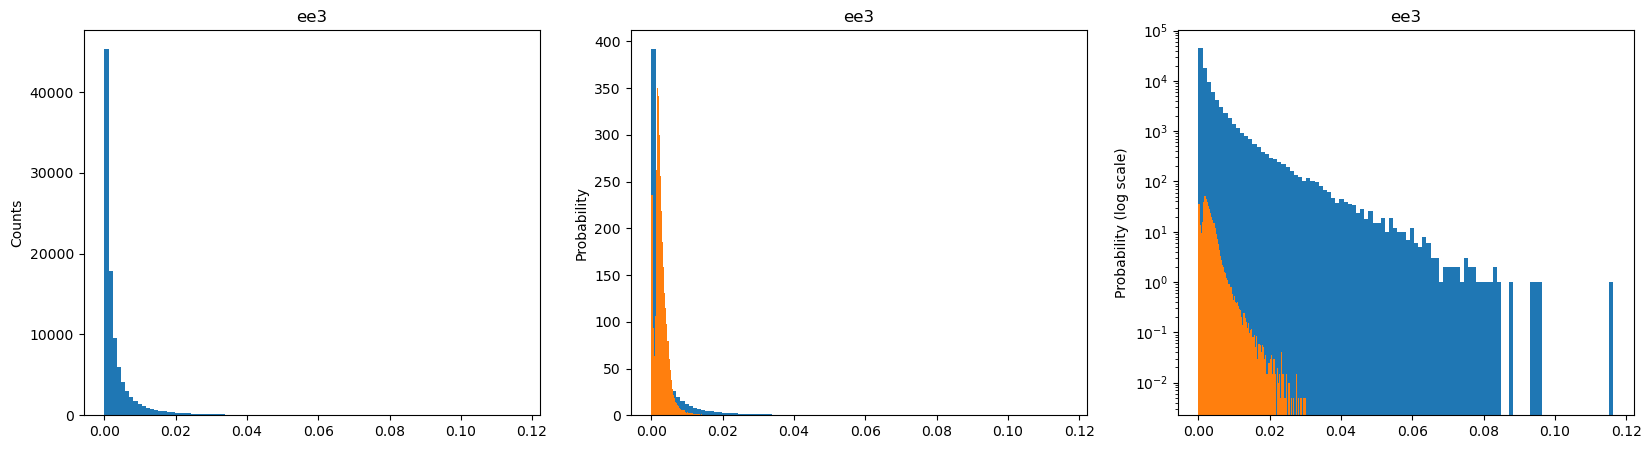

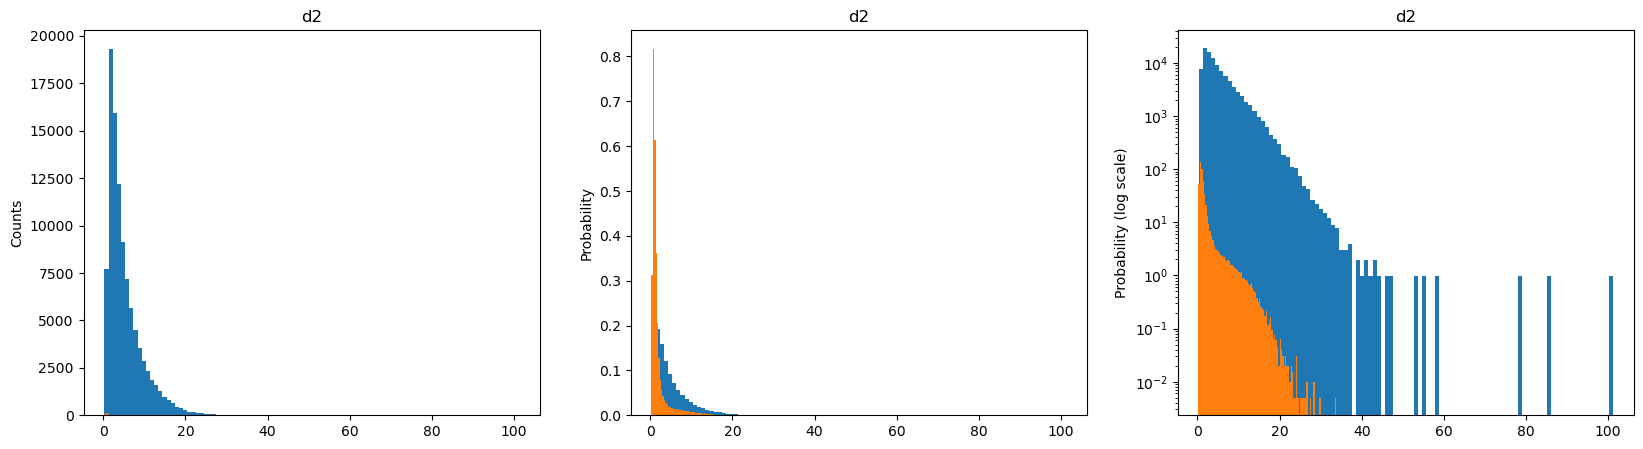

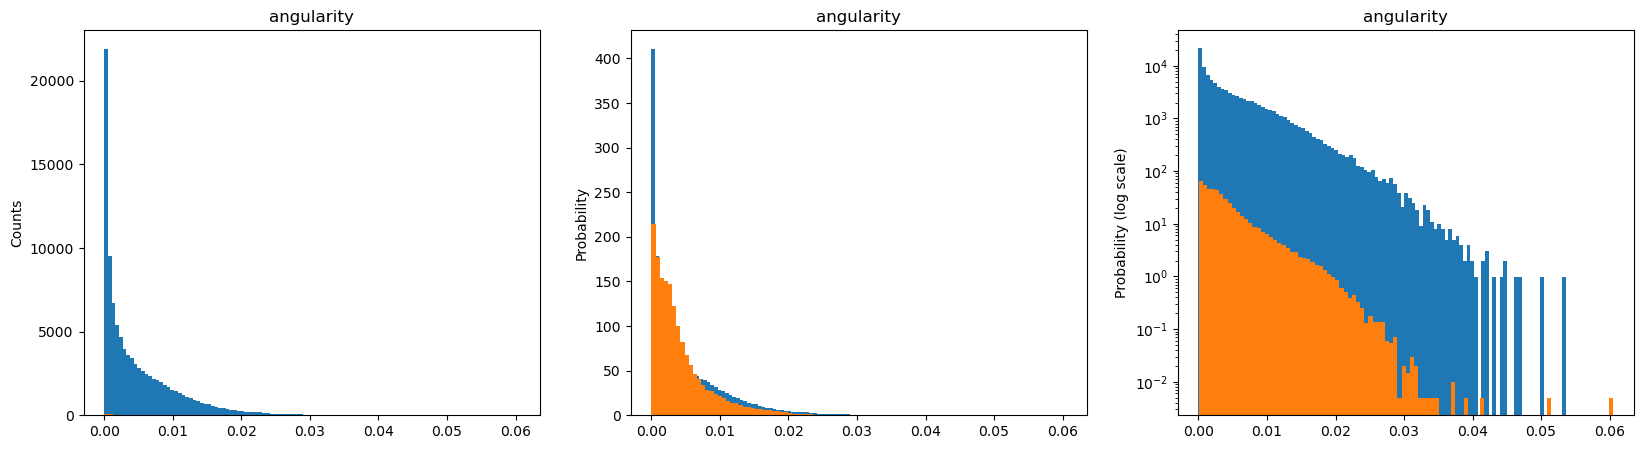

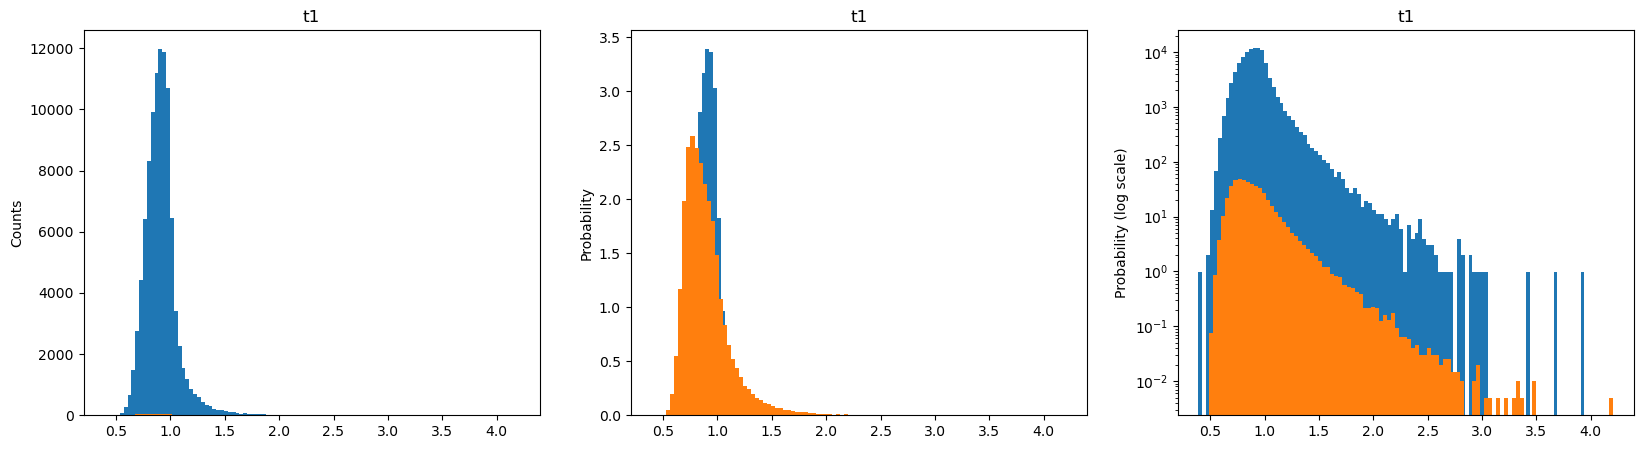

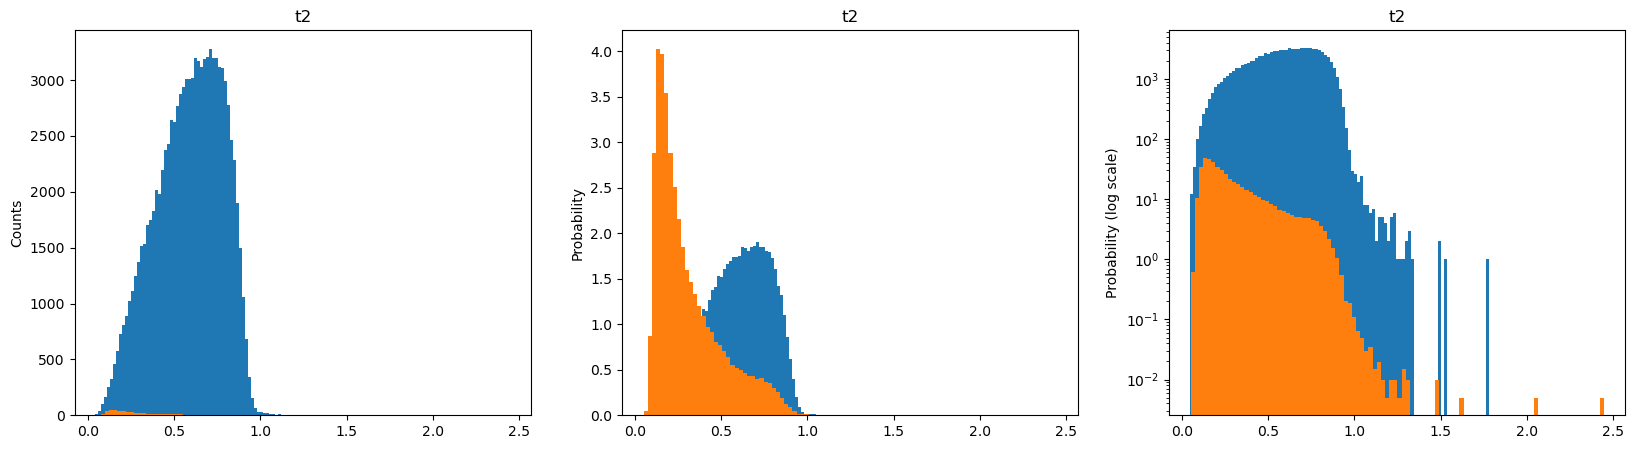

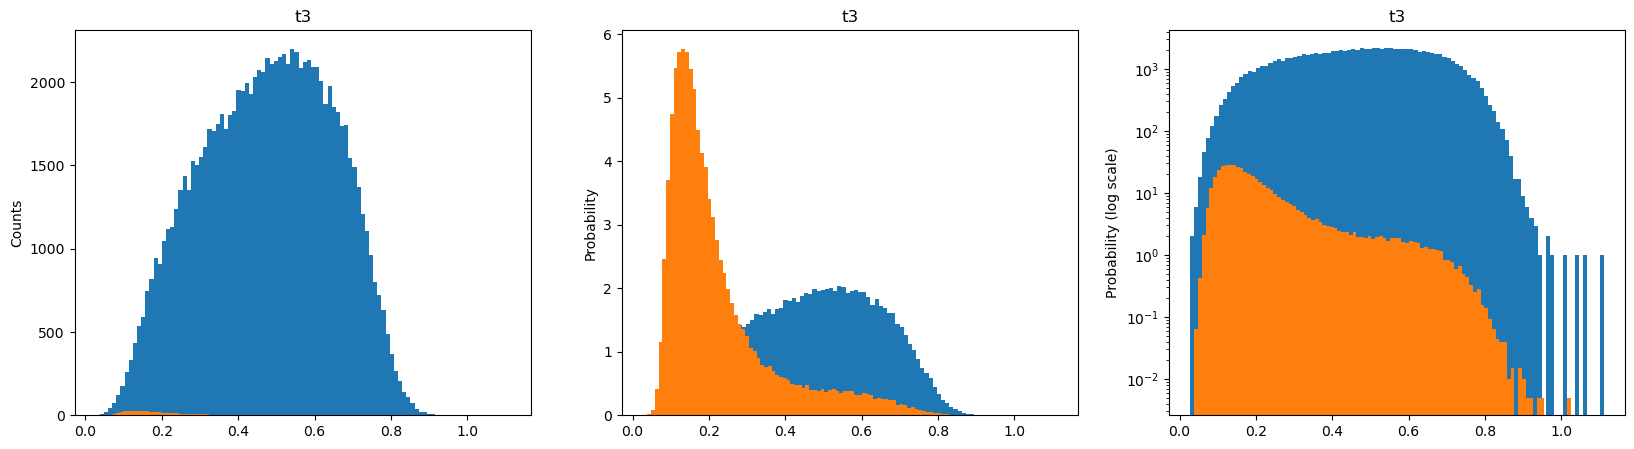

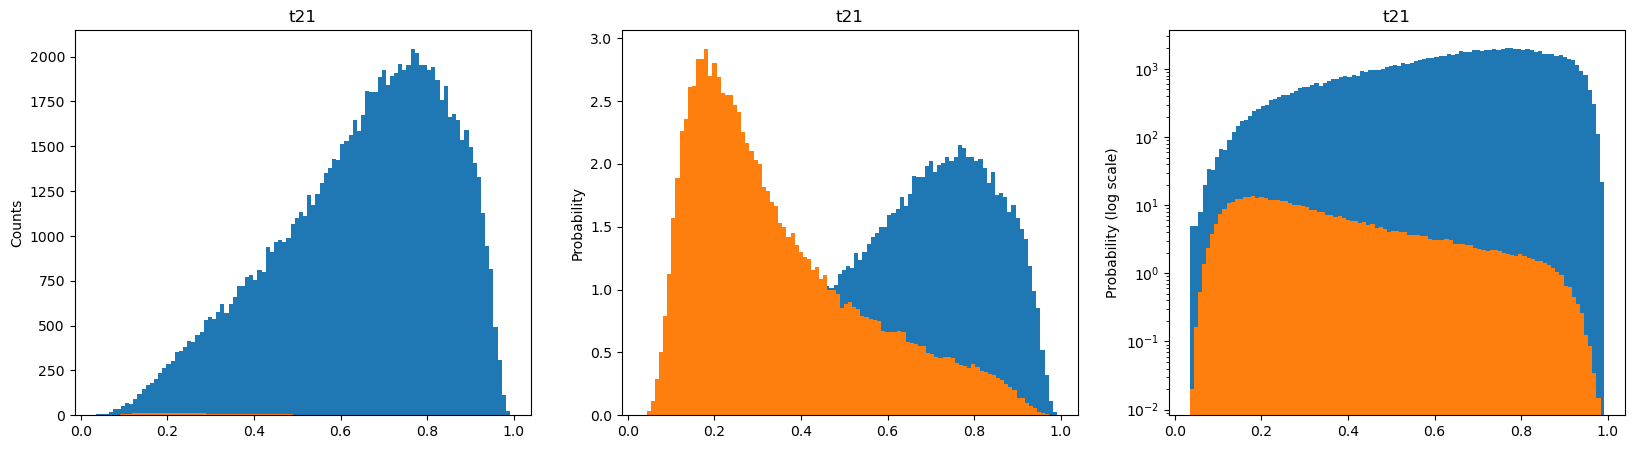

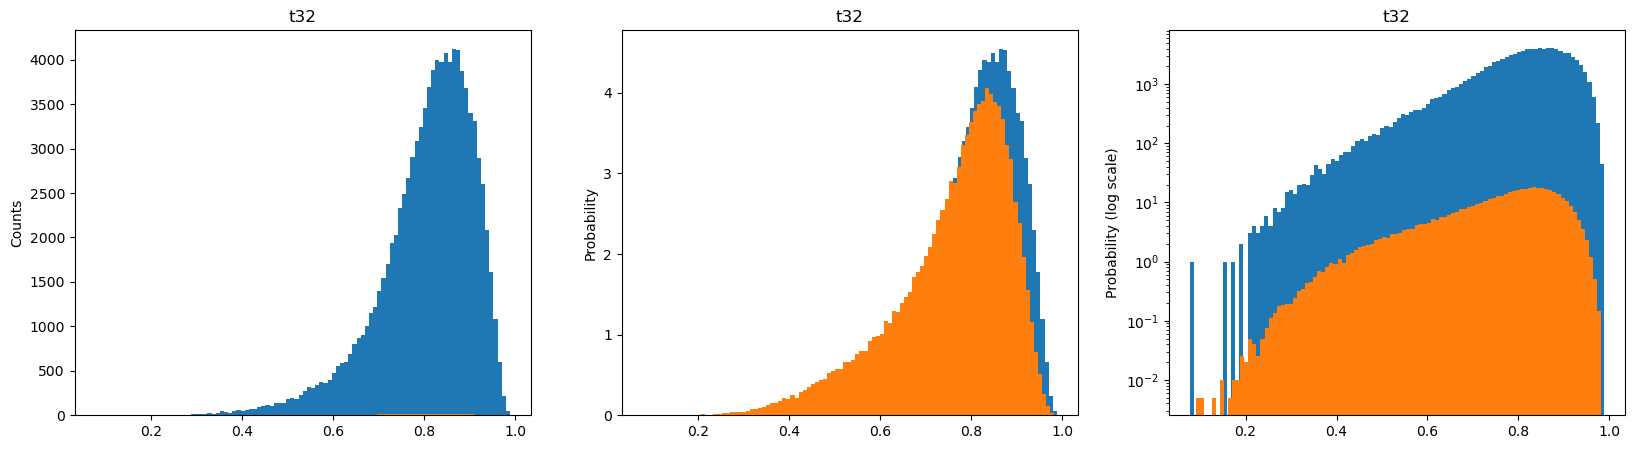

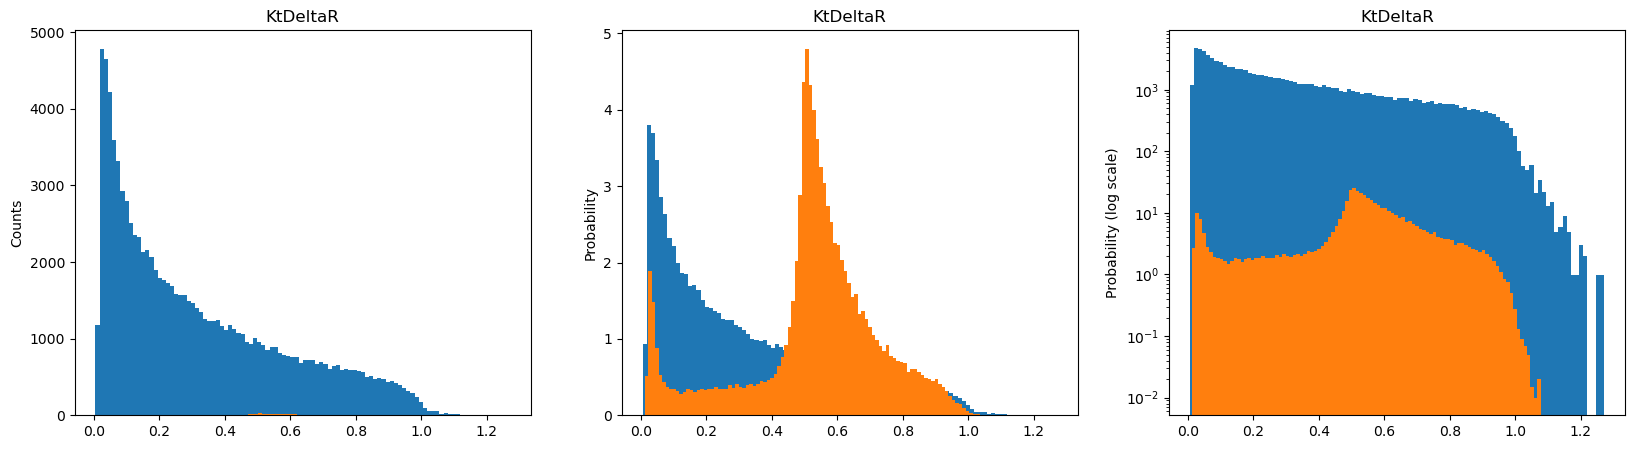

In [20]:
#WITHOUT EVENT SELECTION
parameters = ['pt','eta','phi','ee2','ee3','d2','angularity','t1','t2','t3','t21','t32','KtDeltaR']
for i in parameters:
    hist(i,sample_dict,background_dict)

Looking at the other parameters, it is definately possible to make cuts to improve the significance. First lets try the transverse momentum 

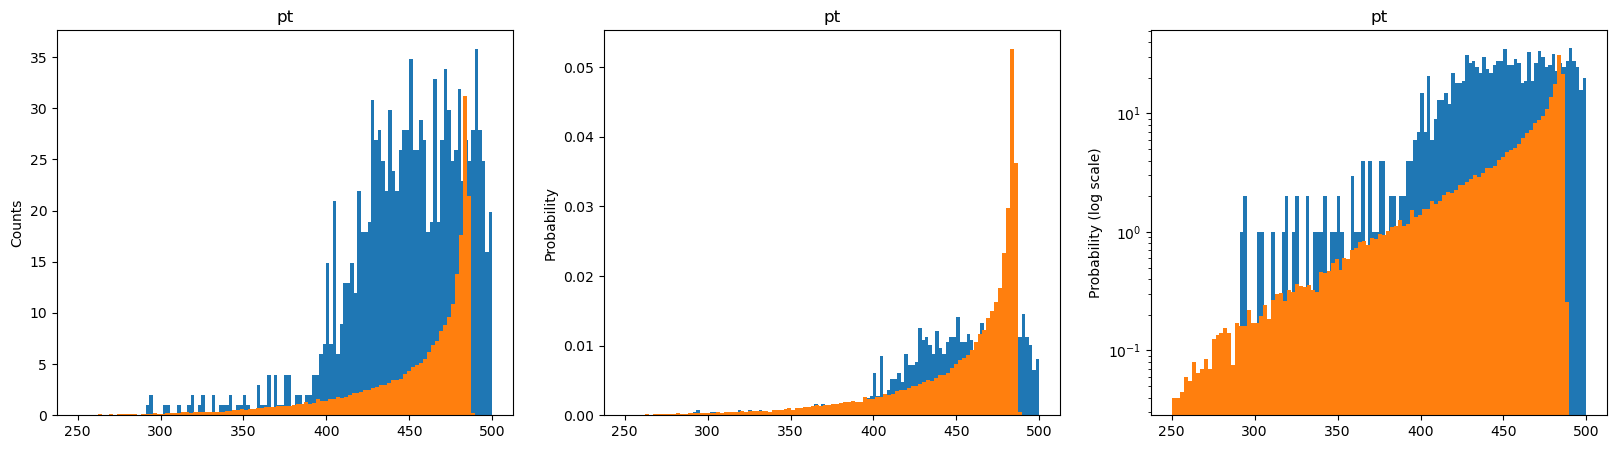

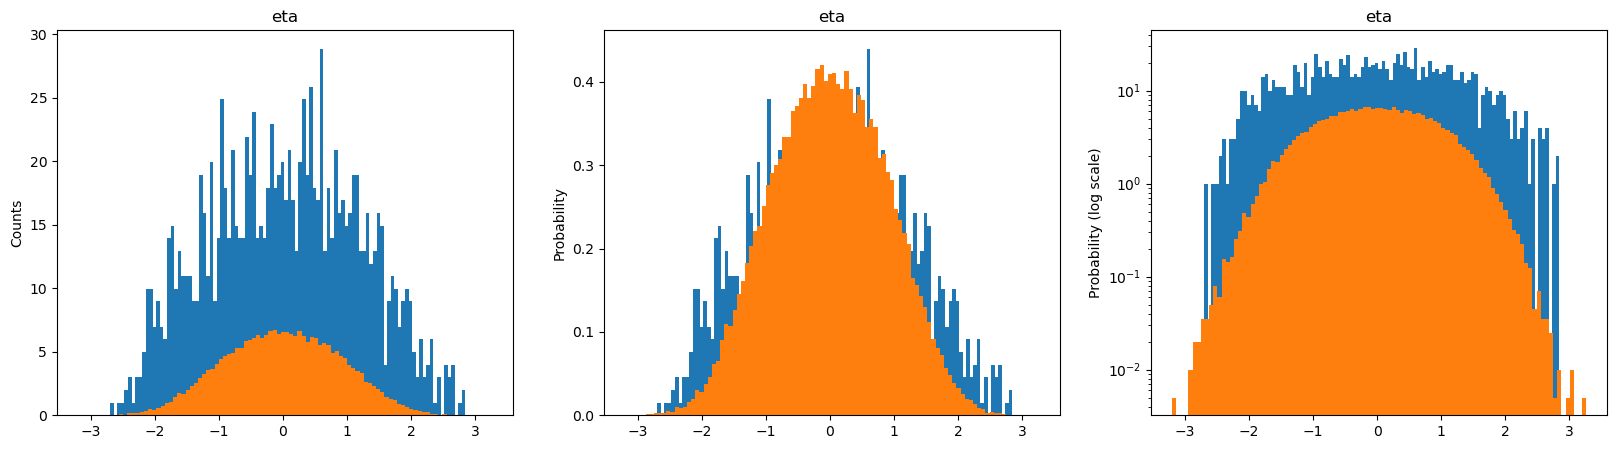

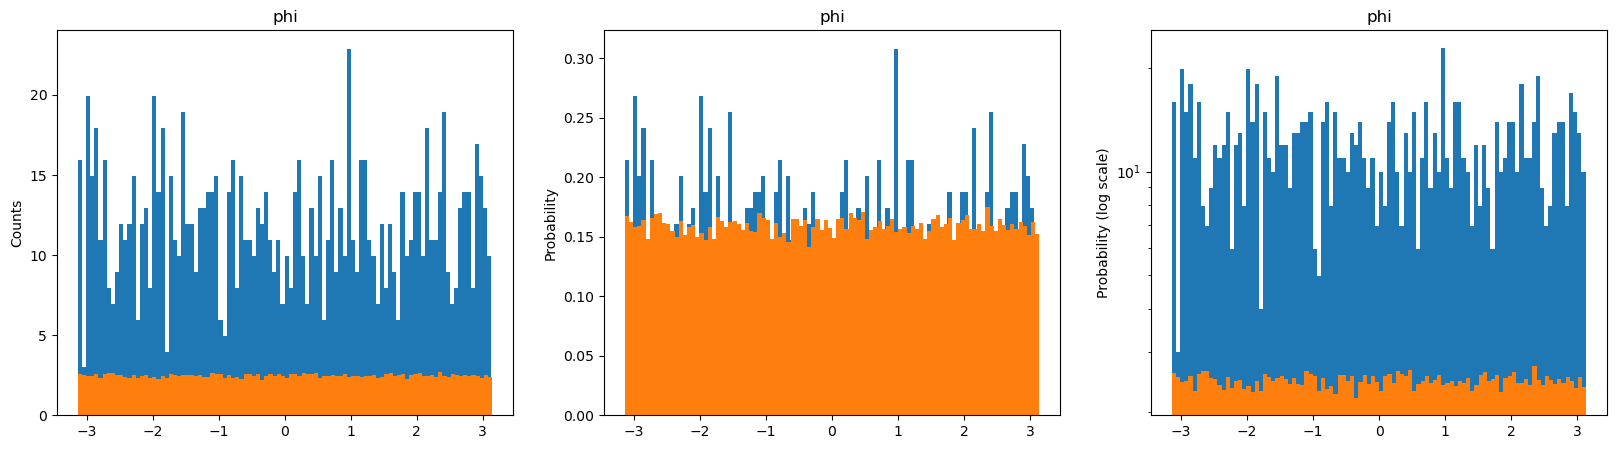

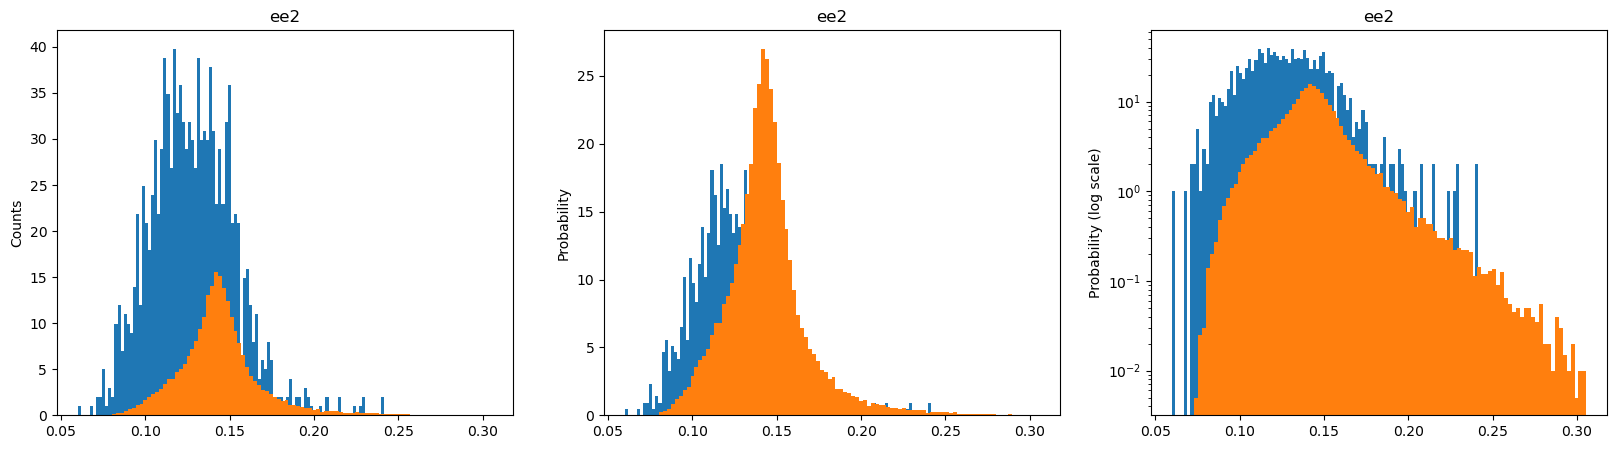

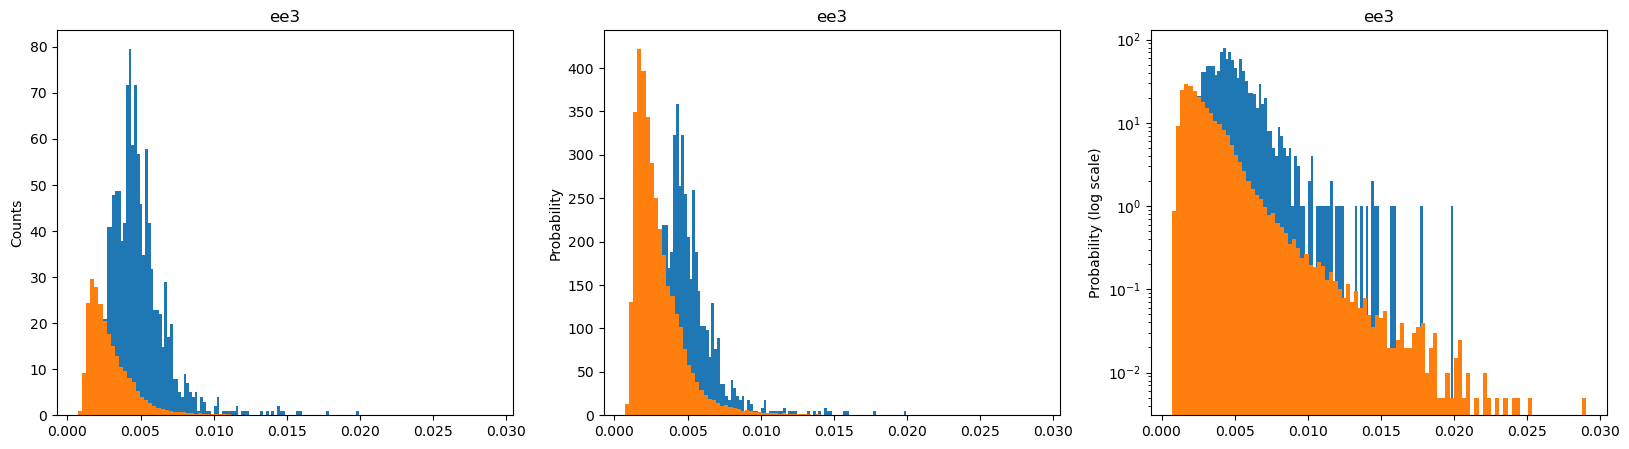

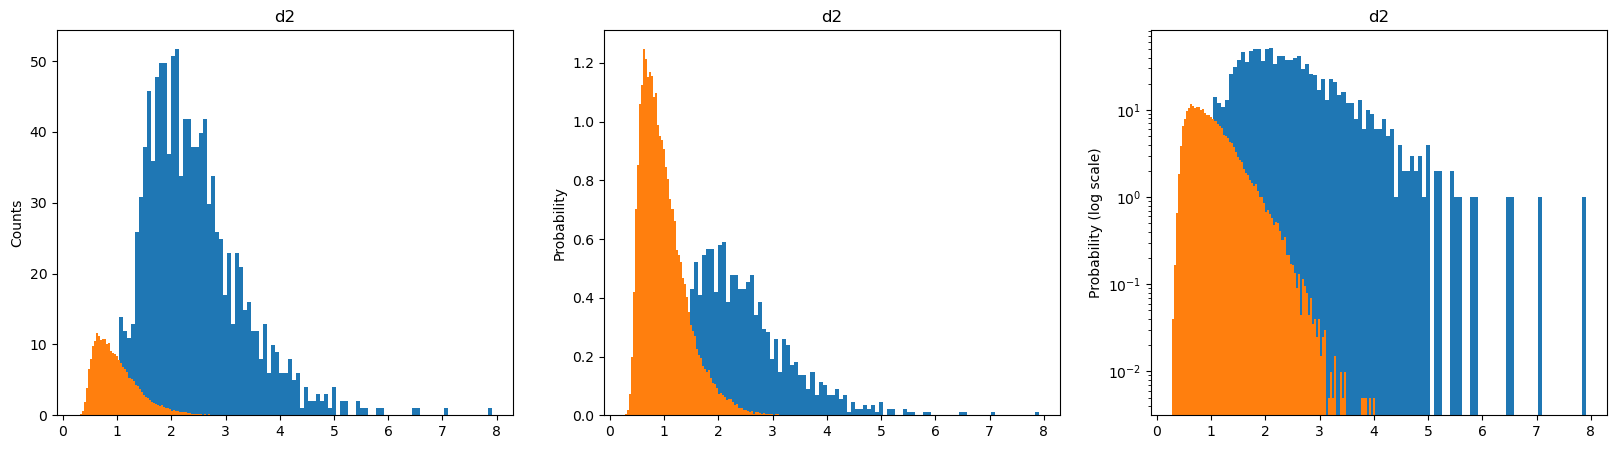

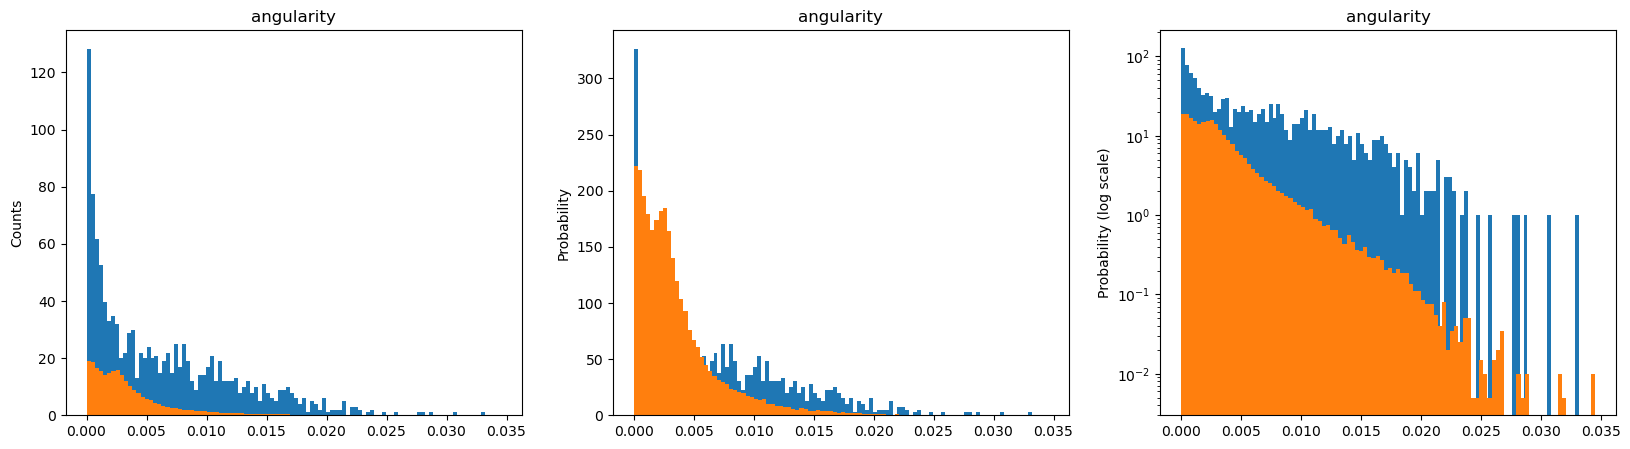

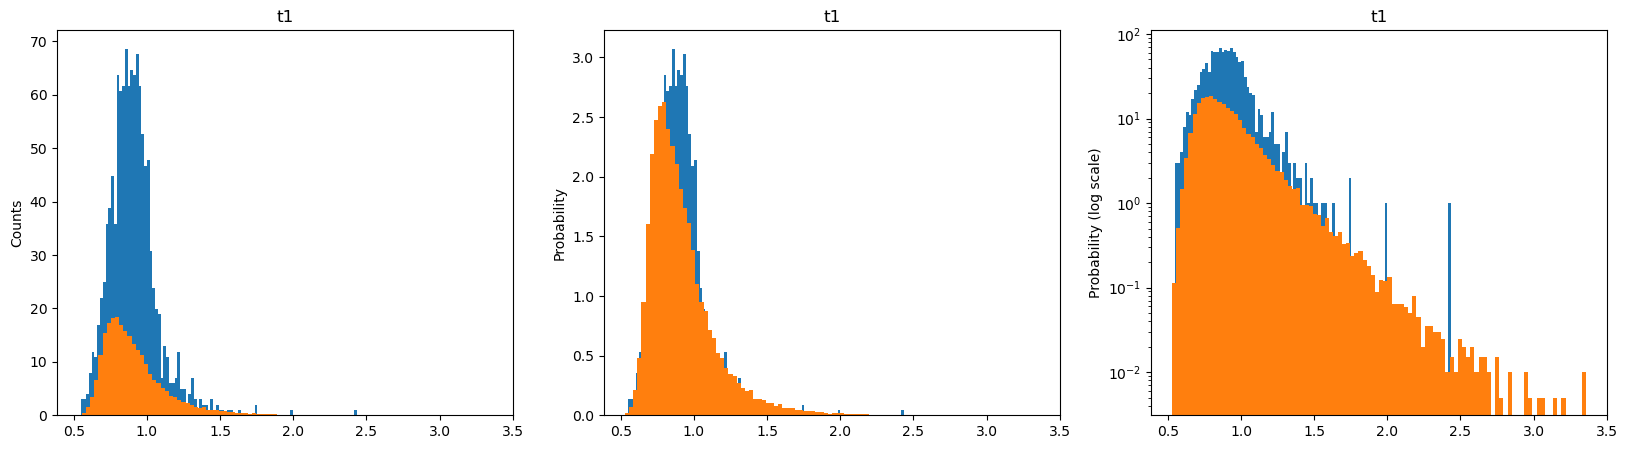

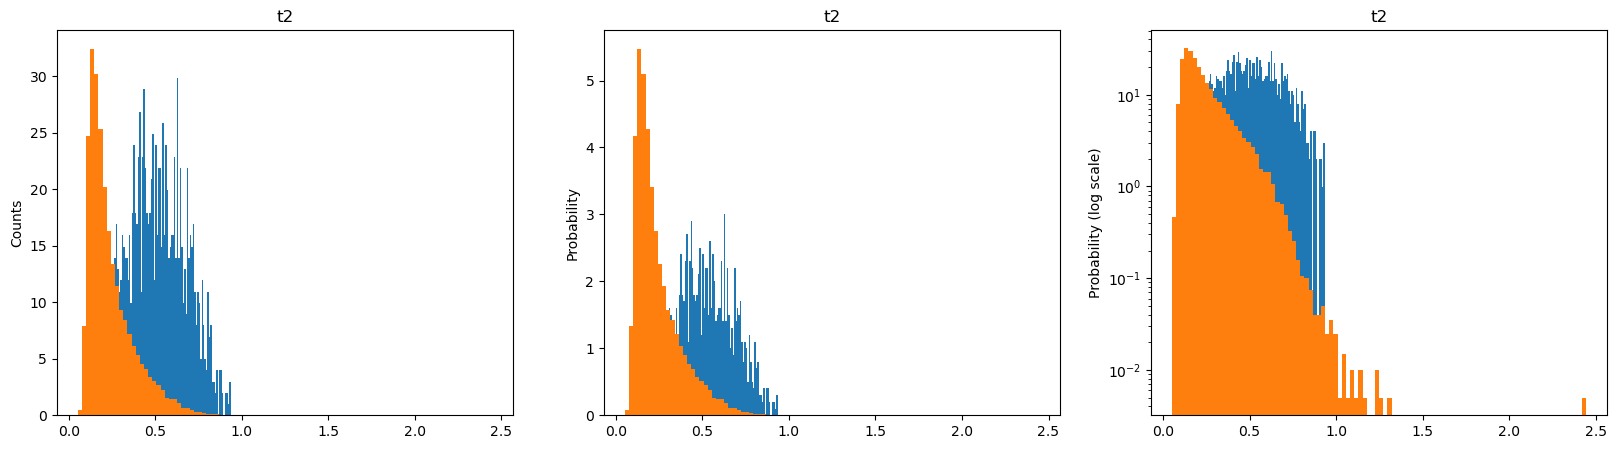

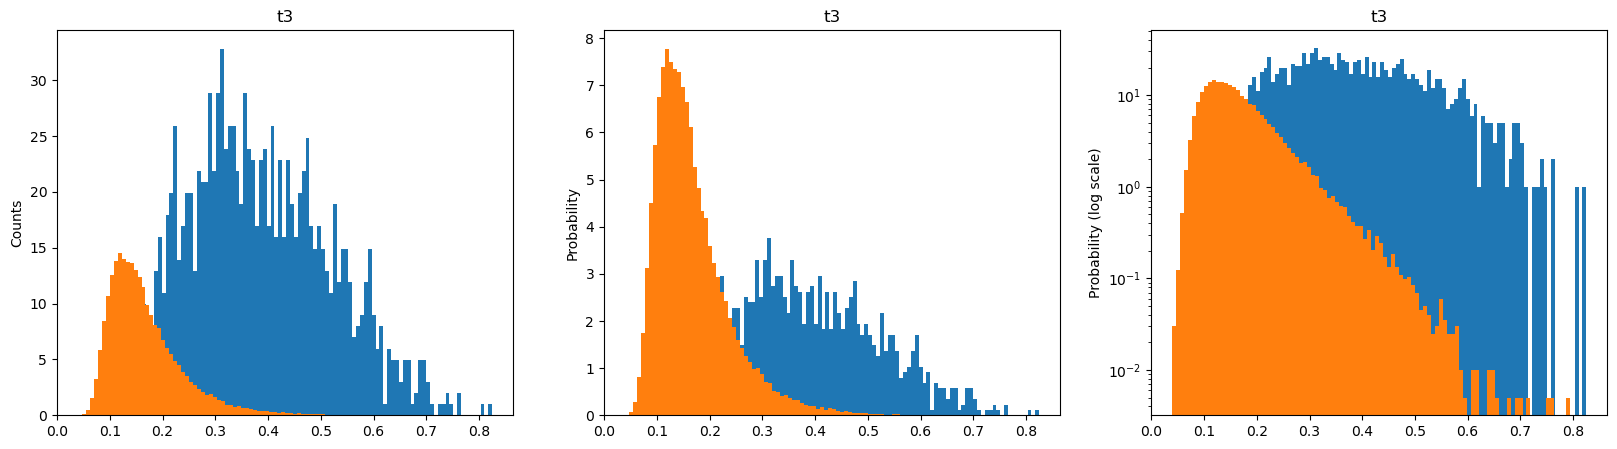

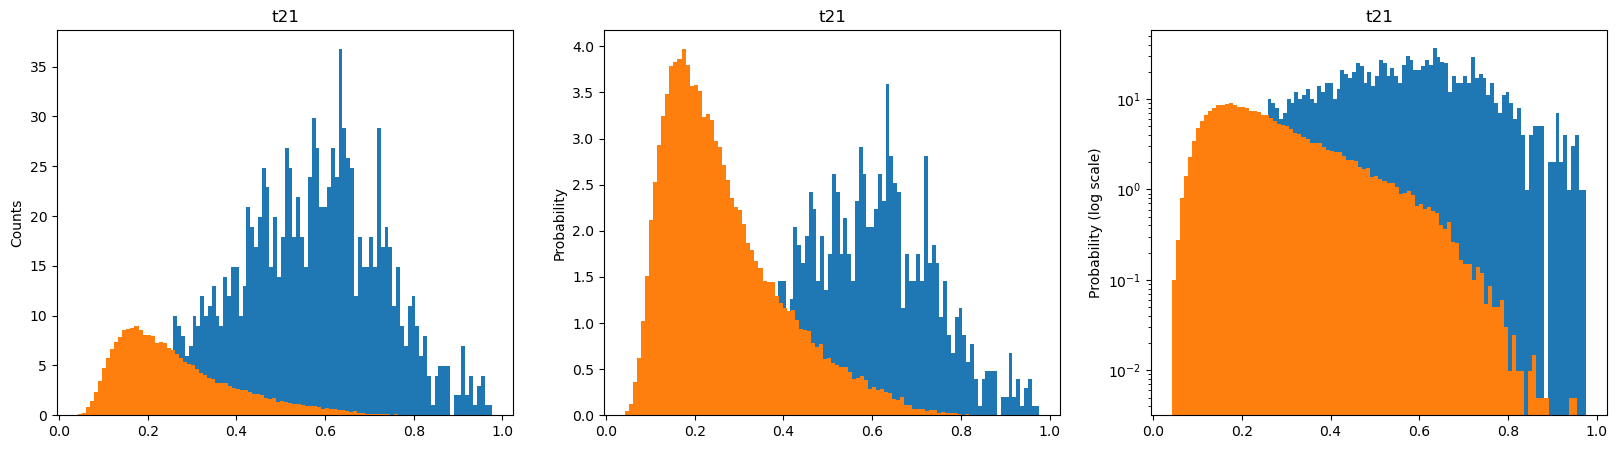

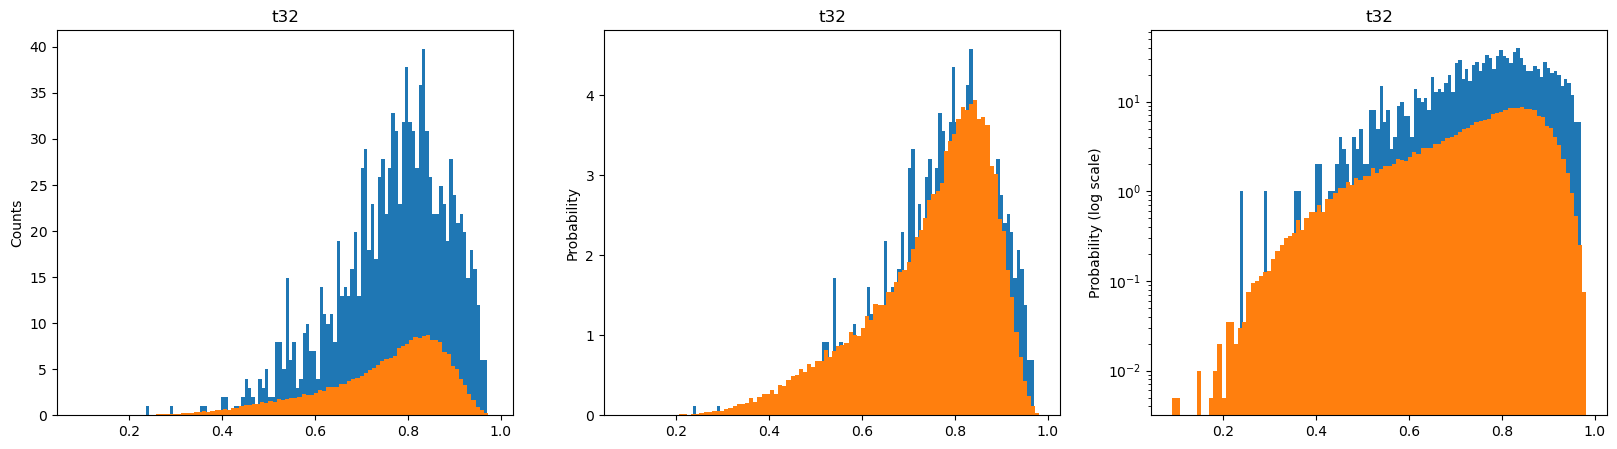

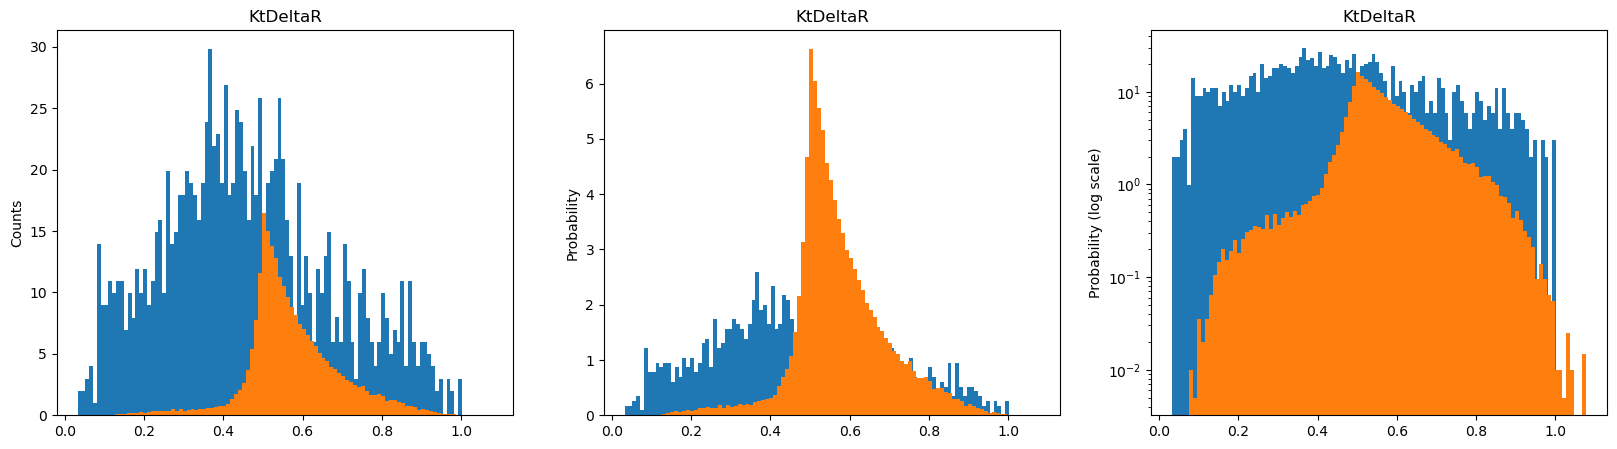

In [21]:
#WITH OPTIMIZED MASS CUTS
for i in parameters:
    hist(i,cut_mass_higgs,cut_mass_qcd)

It is possible to make cuts on ee2, ee3, d2, angularity, t2, t3, t21, ktDeltaR. First, I will make cuts on t21 as it is the most discrimative.

In [22]:
n_higgs_norm = 100/20100
n_qcd_norm = 20000/20100
def cut1(sample_data,background_data,higgs_low_bound,higgs_high_bound,bkd_low_bound,bkd_high_bound,feature):
    
    cut_higgs = sample_data[sample_data[feature]>higgs_low_bound]       #low bound
    cut_qcd = background_data[background_data[feature]>bkd_low_bound]
    
    cut_higgs = cut_higgs[cut_higgs[feature]<higgs_high_bound]      #high bound
    cut_qcd = cut_qcd[cut_qcd[feature]<bkd_high_bound]
    
    fig,ax = plt.subplots(1,3,figsize=(20,5))
    n_higgs_counts,bins1 = np.histogram(cut_higgs[feature],bins = 100)
    n_qcd_counts,bins2 = np.histogram(cut_qcd[feature],bins = 100)

    ax[0].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm)
    ax[0].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm)

    ax[1].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,density=True)
    ax[1].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,density=True)

    ax[2].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm)
    ax[2].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm)
    ax[2].set_yscale('log')

    plt.show()
    return cut_higgs, cut_qcd


In [113]:
def signif1(sample_data,background_data,feature):
    n_higgs = 100
    n_qcd = 20000
    higgs = (sum(sample_data[feature]) / sum(sample_dict[feature])) * n_higgs
    qcd = (sum(background_data[feature]) / sum(background_dict[feature])) * n_qcd

    significance = higgs / np.sqrt(qcd)
    print("Expected Significance: " + str(significance))

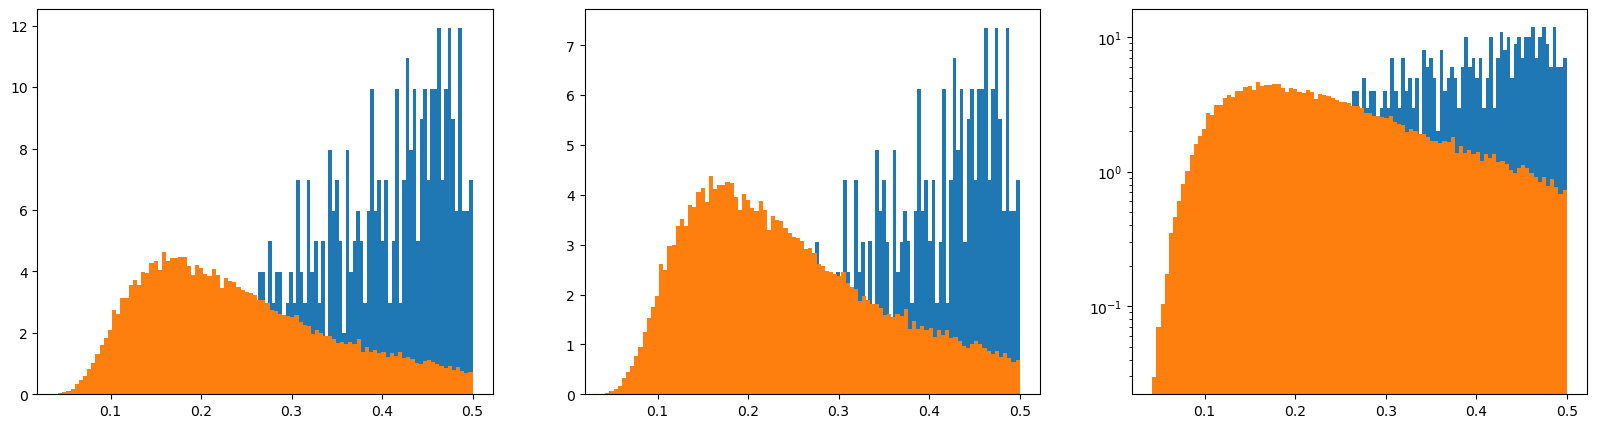

4.584010789439429


In [24]:
cut_t21_higgs, cut_t21_qcd = cut1(cut_mass_higgs,cut_mass_qcd,0,0.50,0,0.50,'t21')
signif1(cut_t21_higgs,cut_t21_qcd,'t21')

Next, I will make cuts on t3

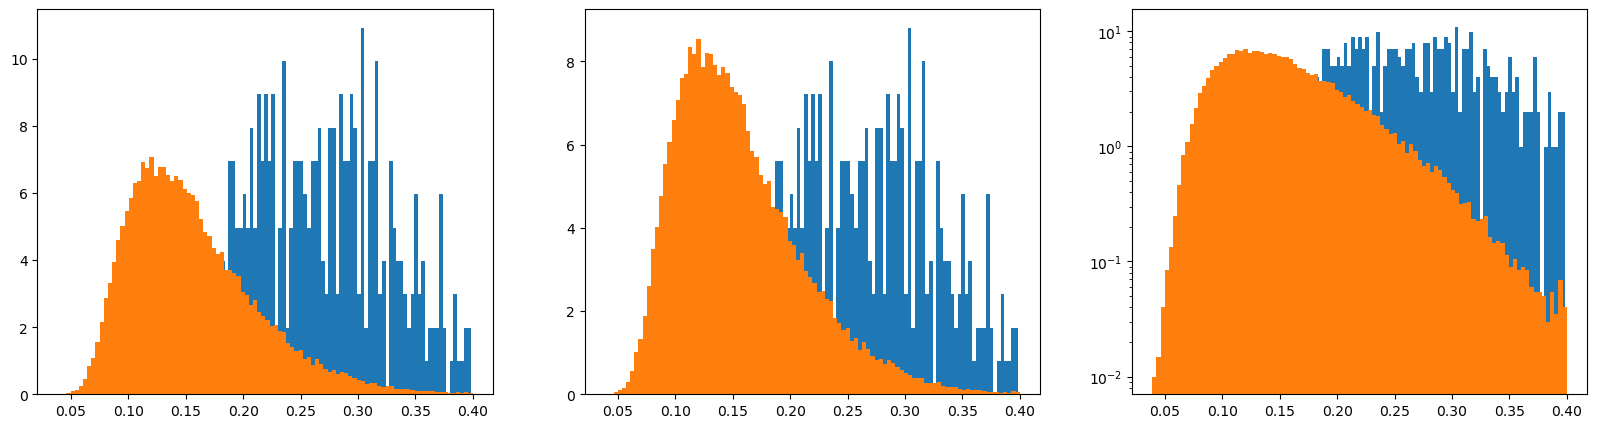

4.8262036738161065


In [25]:
cut_t3_higgs, cut_t3_qcd = cut1(cut_t21_higgs,cut_t21_qcd,0,0.40,0,0.40,'t3')
signif1(cut_t3_higgs,cut_t3_qcd,'t3')

Then t2

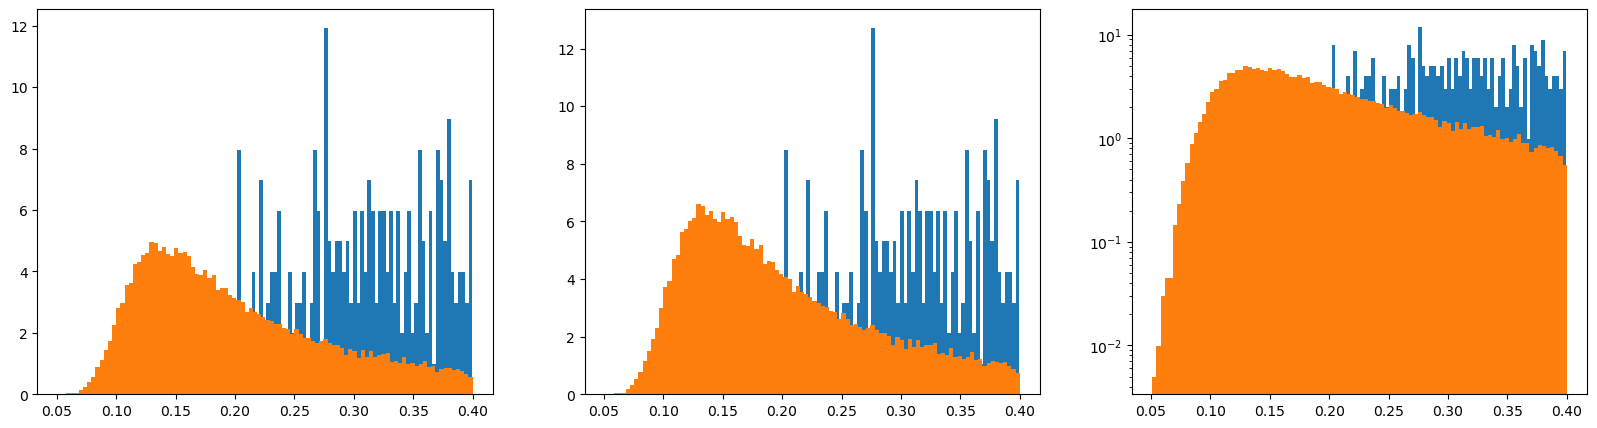

5.023933141212832


In [26]:
cut_t2_higgs, cut_t2_qcd = cut1(cut_t3_higgs,cut_t3_qcd,0,0.40,0,0.40,'t2')
signif1(cut_t2_higgs,cut_t2_qcd,'t2')

Now, KtDeltaR

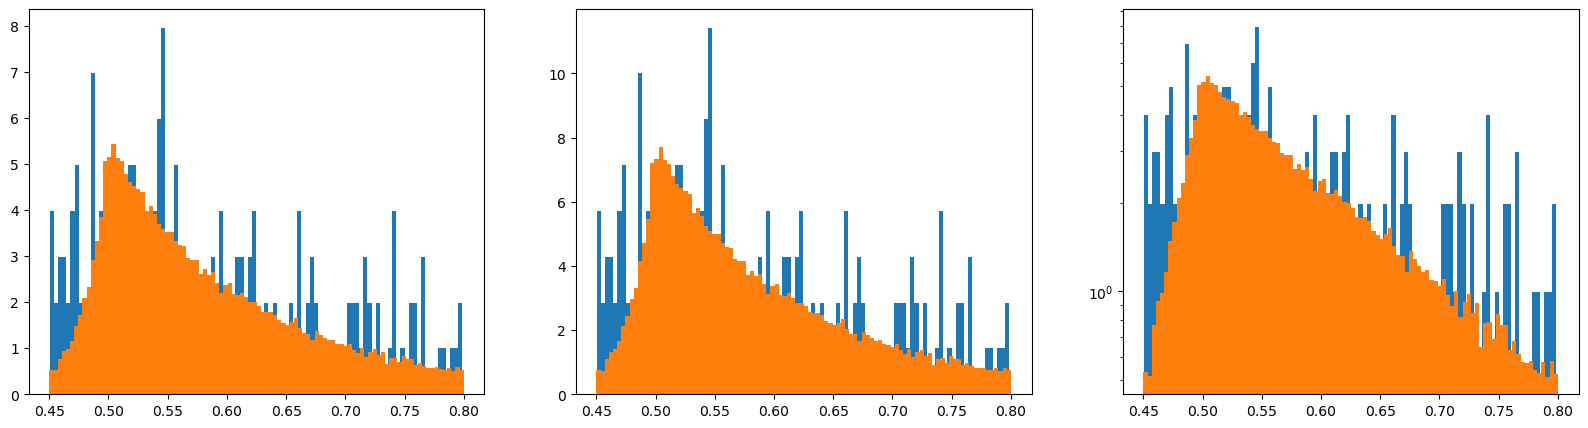

5.190611027920224


In [27]:
cut_KtDeltaR_higgs, cut_KtDeltaR_qcd = cut1(cut_t2_higgs,cut_t2_qcd,0.45,0.80,0.45,0.80,'KtDeltaR')
signif1(cut_KtDeltaR_higgs,cut_KtDeltaR_qcd,'KtDeltaR')

next, angularity

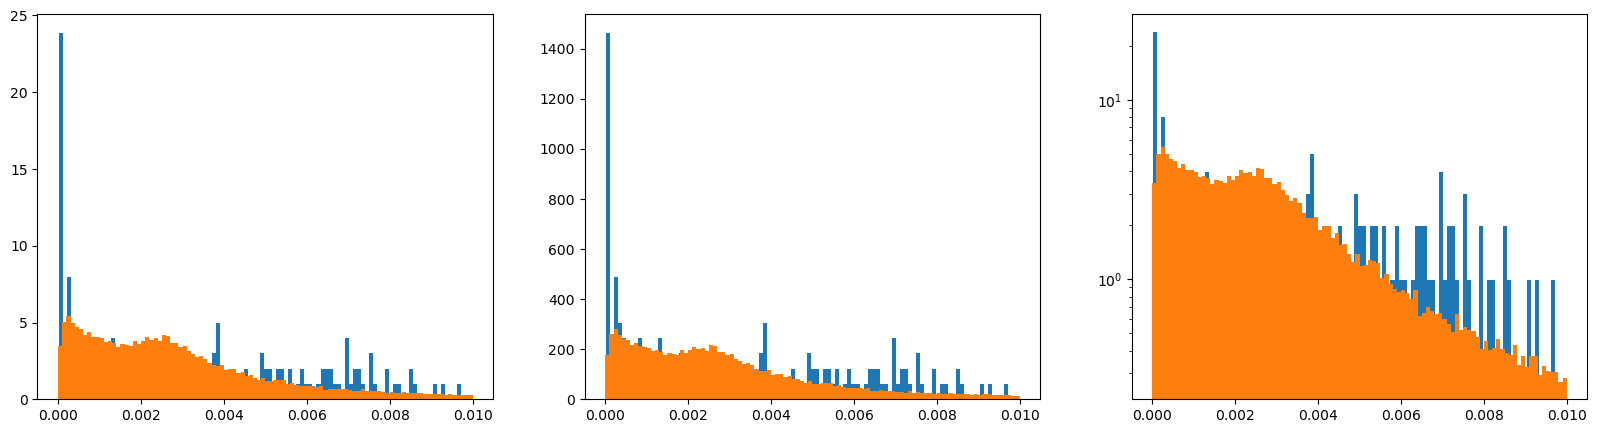

5.60350093514365


In [28]:
cut_angle_higgs, cut_angle_qcd = cut1(cut_KtDeltaR_higgs,cut_KtDeltaR_qcd,0,0.01,0,0.01,'angularity')
signif1(cut_angle_higgs,cut_angle_qcd,'angularity')

next, d2

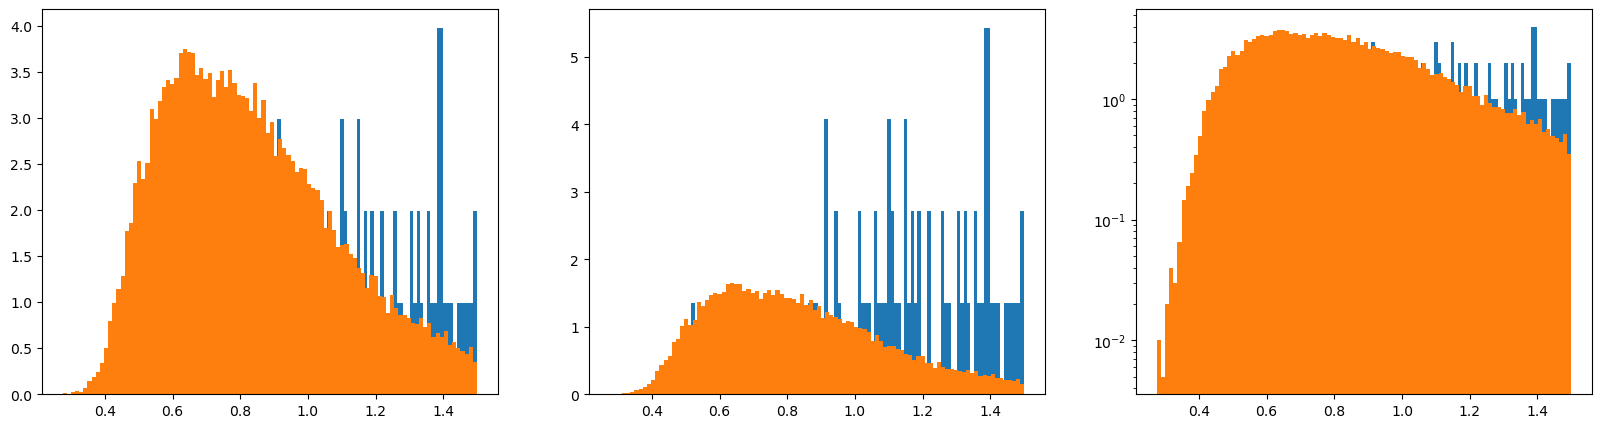

8.587508094837364


In [29]:
cut_d2_higgs, cut_d2_qcd = cut1(cut_angle_higgs,cut_angle_qcd,0,1.5,0,1.5,'d2')
signif1(cut_d2_higgs,cut_d2_qcd,'d2')

This is very good significance. Let's now check the pT plot before and after event selection and compare

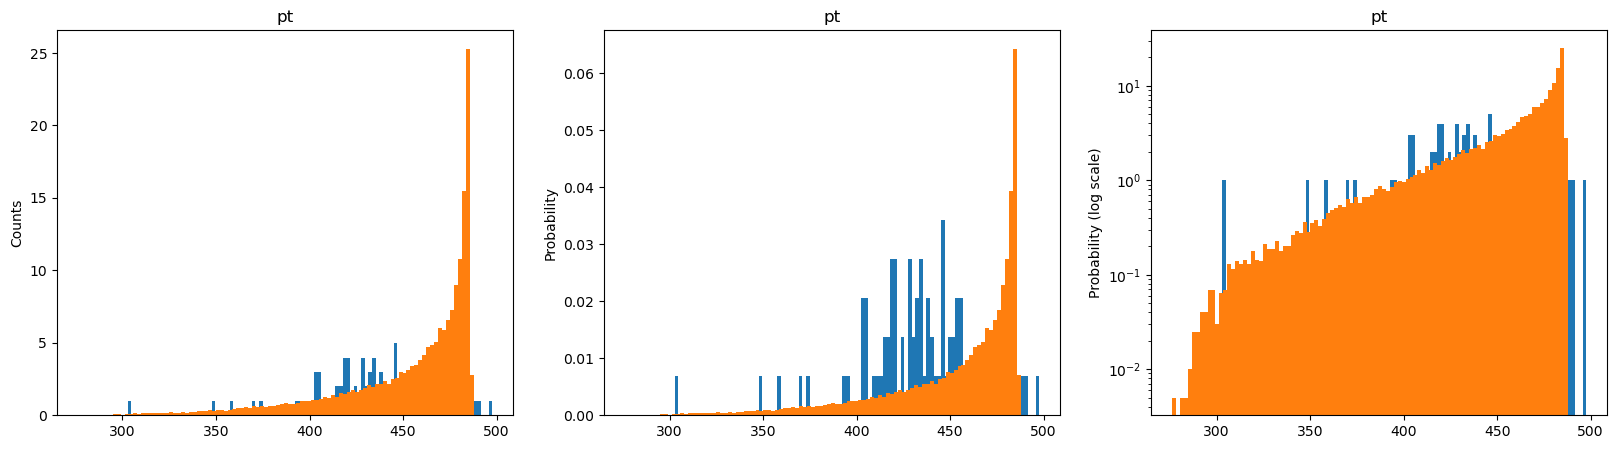

In [30]:
#after event selection 
hist('pt',cut_d2_higgs,cut_d2_qcd)

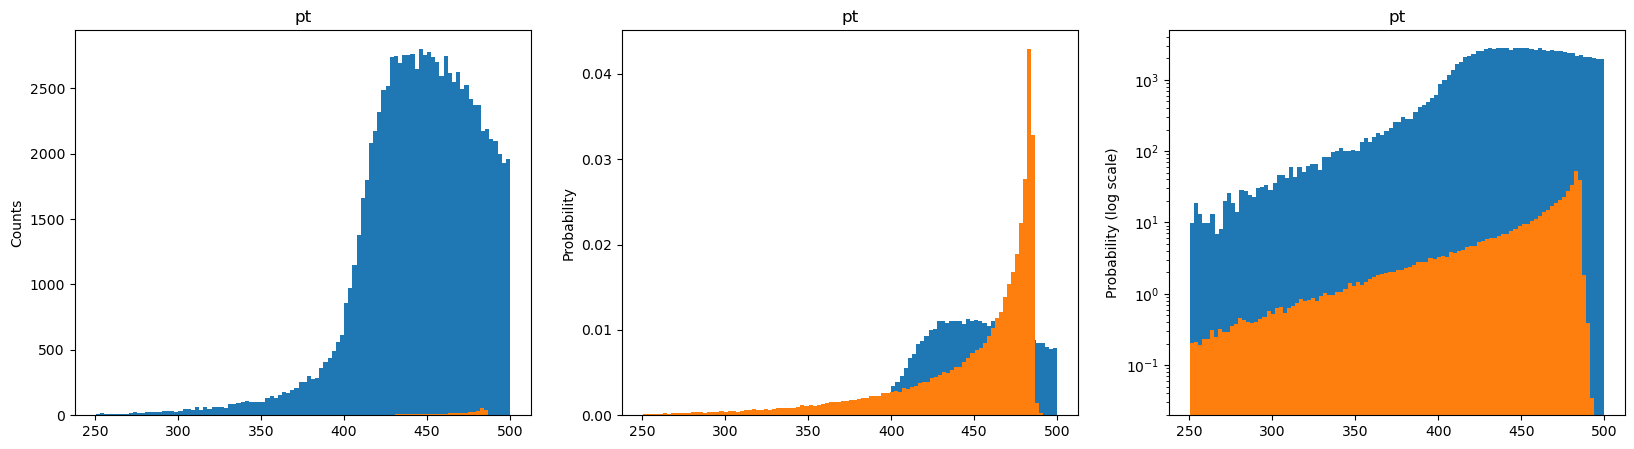

In [31]:
#before event selection 
hist('pt',sample_dict,background_dict)

We can see that the event selection was successful because much of the background has been eliminated while maintainting a good amount of the higgs data.

### Lab 8

In [89]:
highlumi = pandas.read_hdf('data_highLumi_pt_250_500.h5')
highlumi.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

First, we add the high luminosity data to the data done in lab 7 by overlaying the observed data onto the training data.

In [123]:
n_higgs_norm = 100/20100
n_qcd_norm = 20000/20100

def plot_lumi(sample_data,background_data,observed_data,feature,low_bound,high_bound):
    fig,ax = plt.subplots(1,3,figsize=(20,5))
    
    n_obs_norm = sum(observed_data[feature])/sum(observed_data[feature])
    
    n_higgs_counts,bins1 = np.histogram(sample_data[feature],bins = 100)
    n_qcd_counts,bins2 = np.histogram(background_data[feature],bins = 100)
    obs_counts,bins3 = np.histogram(observed_data[feature],bins=100)

    ax[0].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,label="Background")
    ax[0].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,label="Signal")
    ax[0].hist(bins3[:-1], bins3, weights=obs_counts*n_obs_norm,color='red',alpha=0.3,label="Observed Data")
    ax[0].legend(loc='best')

    ax[1].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,density=True,label="Background")
    ax[1].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,density=True,label="Signal")
    ax[1].hist(bins3[:-1], bins3, weights=obs_counts*n_obs_norm,density=True,color='red',alpha=0.3,label="Observed Data")
    ax[1].legend(loc='best')
    
    ax[2].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,label="Background")
    ax[2].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,label="Signal")
    ax[2].hist(bins3[:-1], bins3, weights=obs_counts*n_obs_norm,color='red',alpha=0.3,label="Observed Data")
    ax[2].set_yscale('log')
    ax[2].legend(loc='best')

    plt.show()

In [124]:
n_higgs_norm = 100/20100
n_qcd_norm = 20000/20100

def cut_lumi(sample_data,background_data,observed_data,feature,low_bound,high_bound):
    fig,ax = plt.subplots(1,3,figsize=(20,5))
    
    cut_lumi = observed_data[observed_data[feature]>low_bound]
    cut_lumi = cut_lumi[cut_lumi[feature]<high_bound]
    n_obs_norm = sum(observed_data[feature])/sum(observed_data[feature])
    
    cut_higgs = sample_data[sample_data[feature]>low_bound]
    cut_qcd = background_data[background_data[feature]>low_bound]
    
    cut_higgs = cut_higgs[cut_higgs[feature]<high_bound]
    cut_qcd = cut_qcd[cut_qcd[feature]<high_bound]
    
    n_higgs_counts,bins1 = np.histogram(cut_higgs[feature],bins = 100)
    n_qcd_counts,bins2 = np.histogram(cut_qcd[feature],bins = 100)
    obs_counts,bins3 = np.histogram(cut_lumi[feature],bins=100)

    ax[0].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,label="Background")
    ax[0].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,label="Signal")
    ax[0].hist(bins3[:-1], bins3, weights=obs_counts*n_obs_norm,color='red',label="Observed Data",alpha=0.3)
    ax[0].legend(loc='best')

    ax[1].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,density=True,label="Background")
    ax[1].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,density=True,label="Signal")
    ax[1].hist(bins3[:-1], bins3, weights=obs_counts*n_obs_norm,density=True,color='red',label="Observed Data",alpha=0.3)
    ax[1].legend(loc='best')

    ax[2].hist(bins2[:-1], bins2, weights=n_qcd_counts*n_qcd_norm,label="Background")
    ax[2].hist(bins1[:-1], bins1, weights=n_higgs_counts*n_higgs_norm,label="Signal")
    ax[2].hist(bins3[:-1], bins3, weights=obs_counts*n_obs_norm,color='red',label="Observed Data",alpha=0.3)
    ax[2].legend(loc='best')
    ax[2].set_yscale('log')

    plt.show()
    return cut_higgs, cut_qcd, cut_lumi

In [125]:
def lumi_sig(cut_higgs,cut_qcd,cut_lumi,feature,lumi):
    n_higgs = 100
    n_qcd = 20000
    higgs = (sum(cut_higgs[feature]) / sum(sample_dict[feature])) * n_higgs
    lumi = (sum(cut_lumi[feature]) / sum(lumi[feature])) * n_qcd

    significance = higgs / np.sqrt(lumi)
    print("Observed Significance: " + str(significance))

I will overlap the observed data on the sample data with optimal cuts and compare the significance.

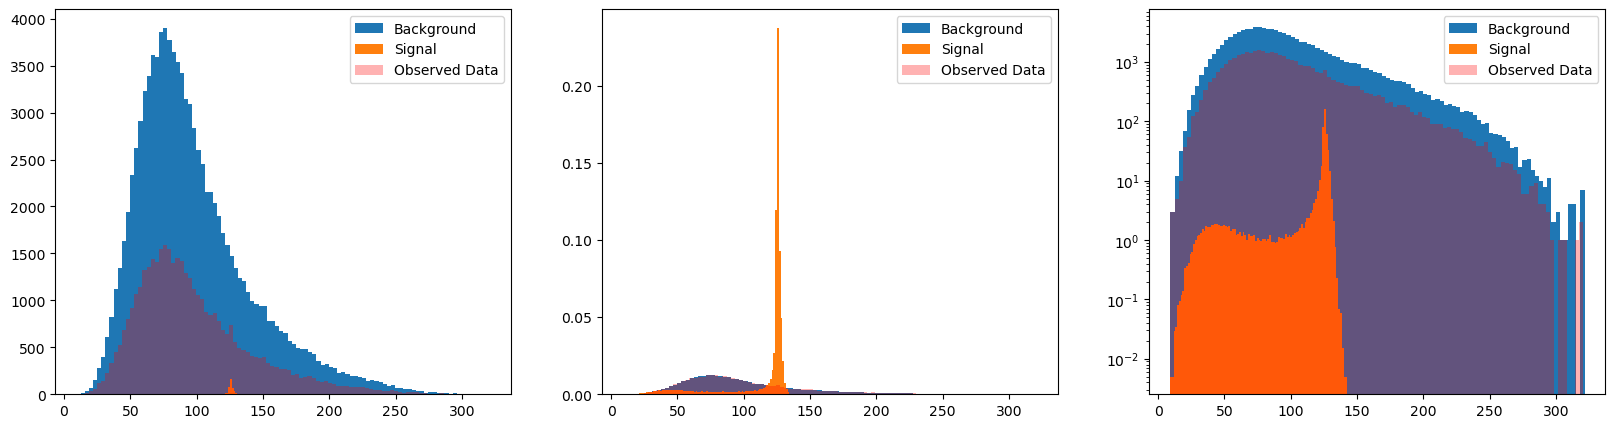

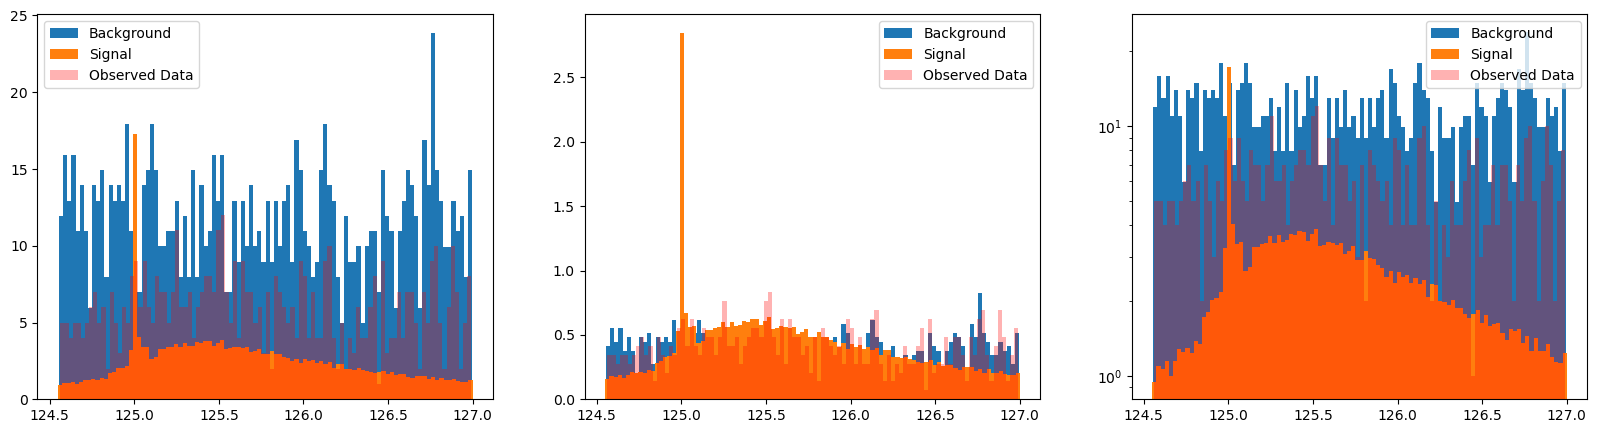

Expected Significance: 3.1065303151335293
Observed Significance: 2.7934212597565553


In [126]:
plot_lumi(sample_dict,background_dict,highlumi,'mass',0,500)
cut_mass_higgs, cut_mass_qcd, cut_mass_highlumi = cut_lumi(sample_dict,background_dict,highlumi,'mass',124.55,127)
signif1(cut_mass_higgs,cut_mass_qcd,'mass')
lumi_sig(cut_mass_higgs,cut_mass_qcd, cut_mass_highlumi,'mass',highlumi)

Next, I will do this with the same parameters used in the lab 7 to improve the significance and compare with the significance used observed in lab 7.

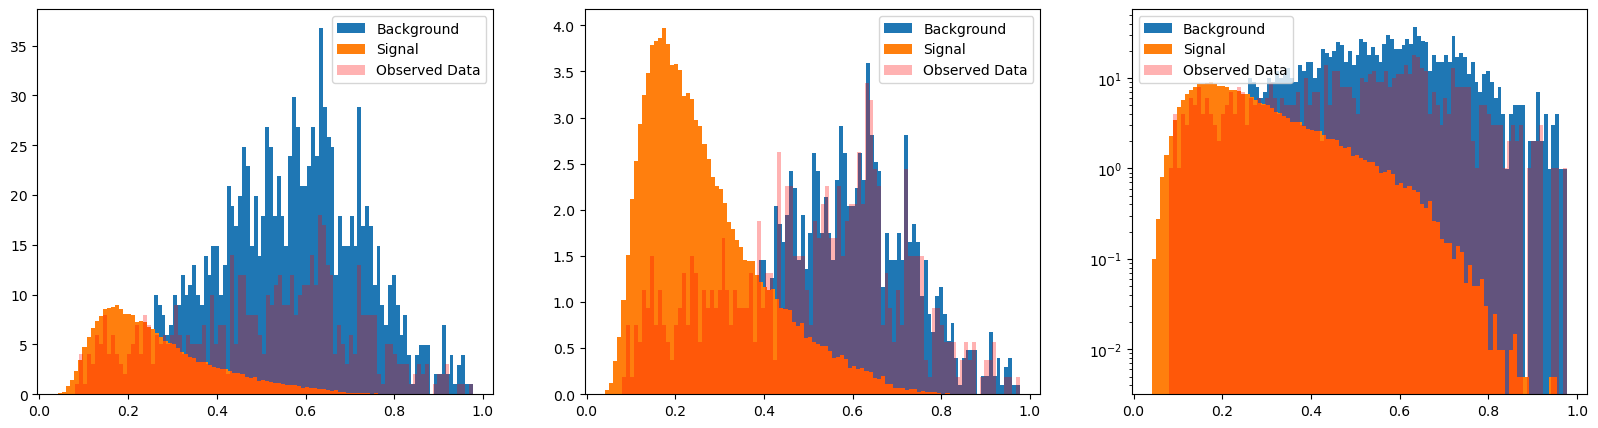

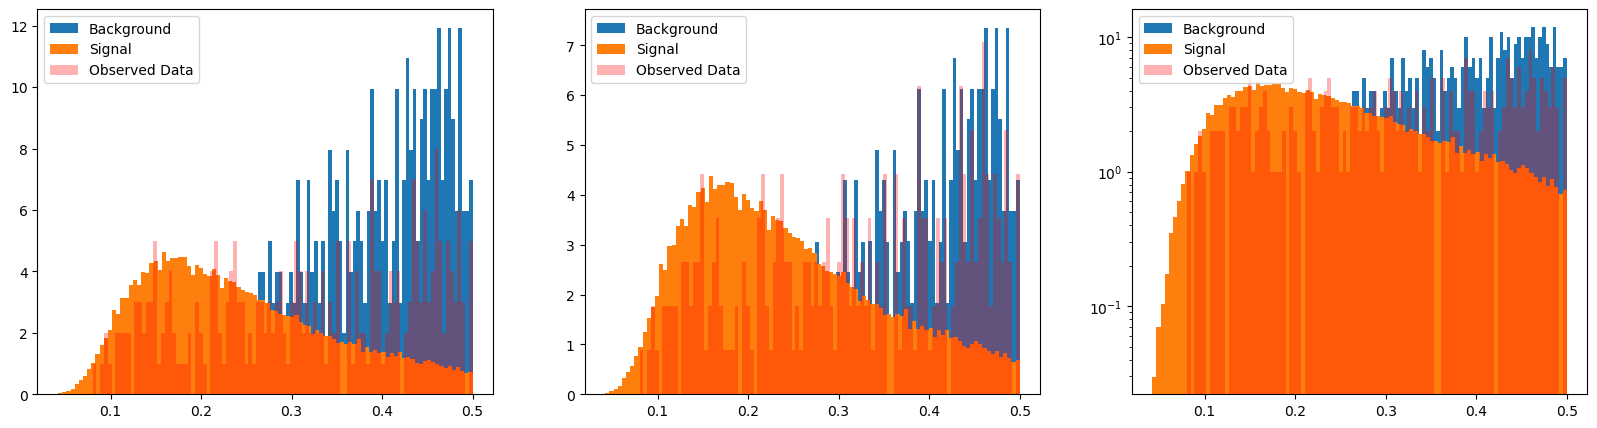

4.584010789439429
3.9375365846257573


In [110]:
plot_lumi(cut_mass_higgs,cut_mass_qcd,cut_mass_highlumi,'t21',0,500)
cut_t21_higgs, cut_t21_qcd, cut_t21_highlumi = cut_lumi(cut_mass_higgs,cut_mass_qcd,cut_mass_highlumi,'t21',0,0.50)
signif1(cut_t21_higgs,cut_t21_qcd,'t21')
lumi_sig(cut_t21_higgs,cut_t21_qcd, cut_t21_highlumi,'t21',highlumi)

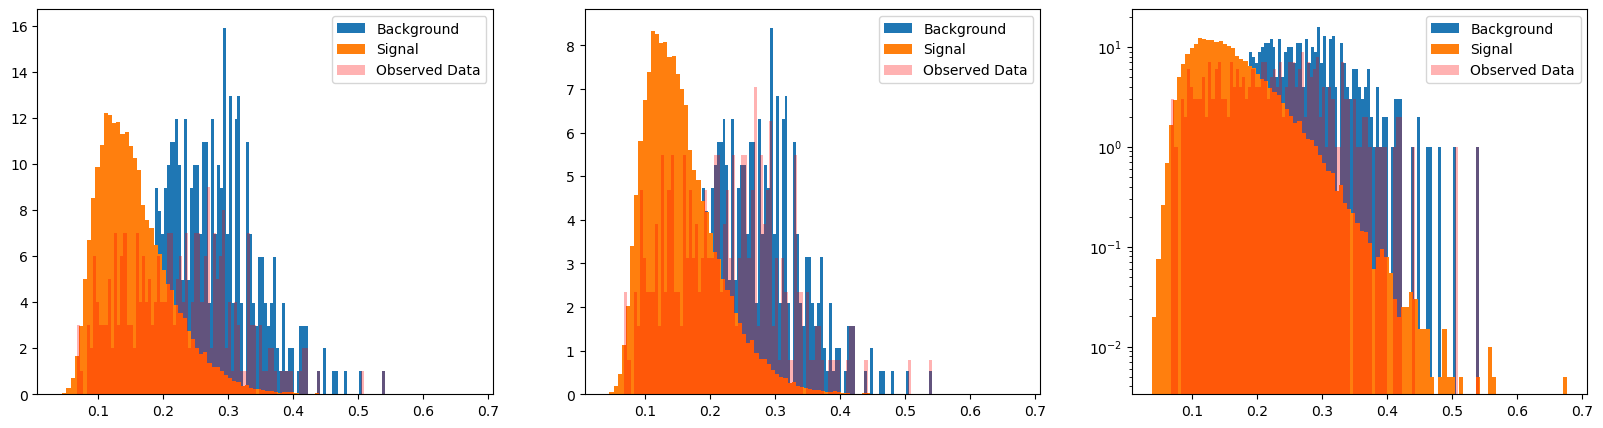

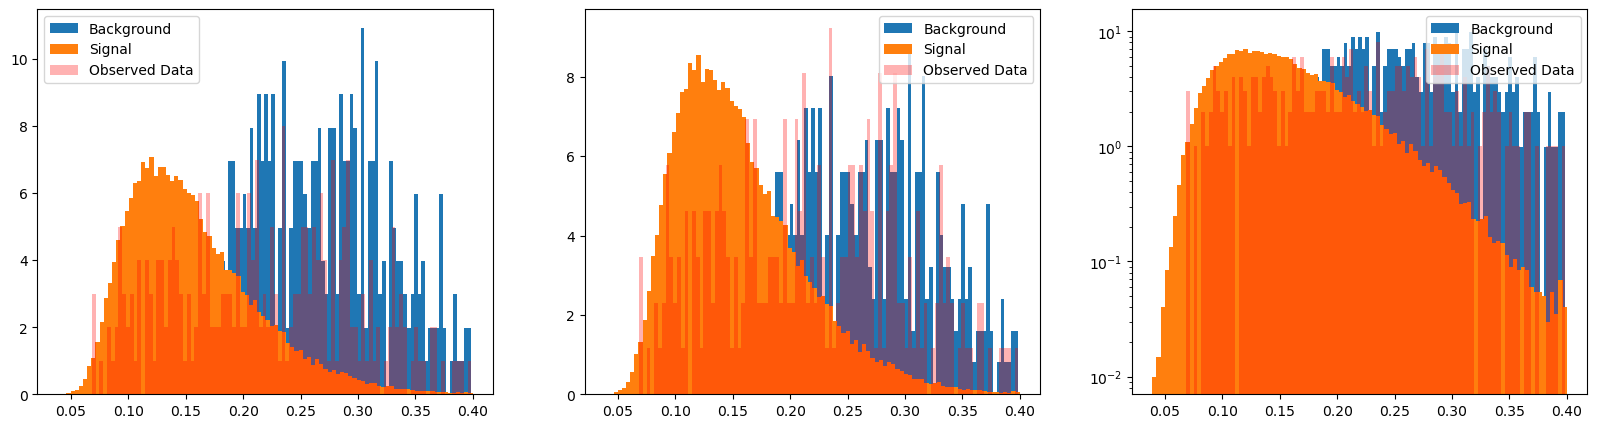

Expected Significance: 4.8262036738161065
Observed Significance: 4.106255681013995


In [116]:
#t3
plot_lumi(cut_t21_higgs,cut_t21_qcd,cut_t21_highlumi,'t3',0,500)
cut_t3_higgs, cut_t3_qcd, cut_t3_highlumi = cut_lumi(cut_t21_higgs,cut_t21_qcd,cut_t21_highlumi,'t3',0,0.40)
signif1(cut_t3_higgs,cut_t3_qcd,'t3')
lumi_sig(cut_t3_higgs,cut_t3_qcd, cut_t3_highlumi,'t3',highlumi)

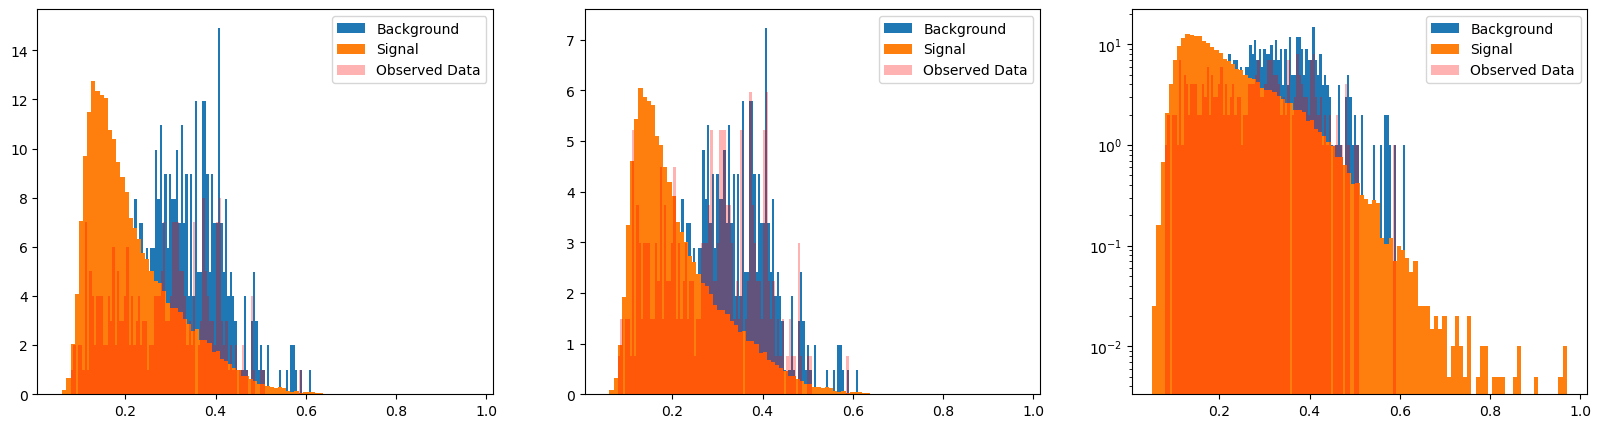

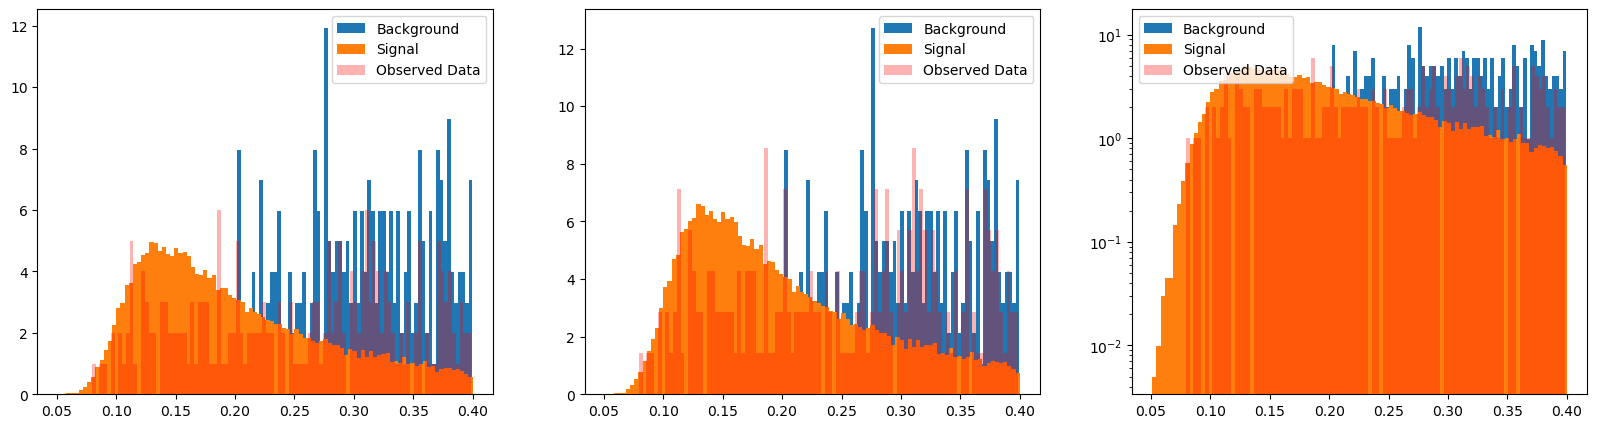

Expected Significance: 5.023933141212832
Observed Significance: 4.081977570330204


In [117]:
#t2
plot_lumi(cut_t3_higgs,cut_t3_qcd,cut_t3_highlumi,'t2',0,500)
cut_t2_higgs, cut_t2_qcd, cut_t2_highlumi = cut_lumi(cut_t3_higgs,cut_t3_qcd,cut_t3_highlumi,'t2',0,0.40)
signif1(cut_t2_higgs,cut_t2_qcd,'t2')
lumi_sig(cut_t2_higgs,cut_t2_qcd, cut_t2_highlumi,'t2',highlumi)

In this case, the significance actually decreases...

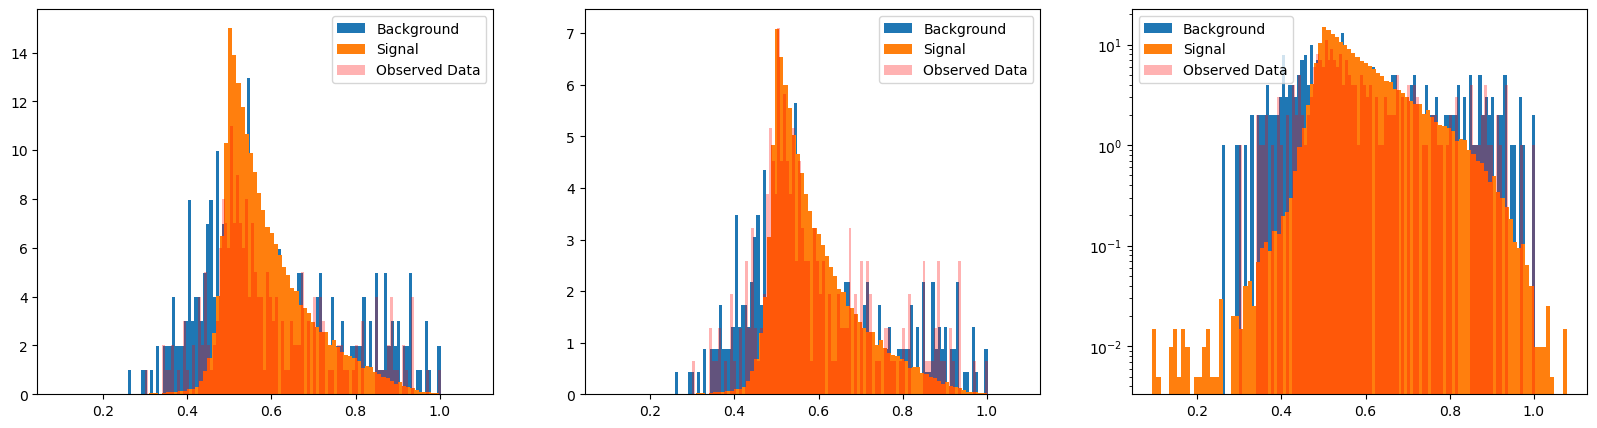

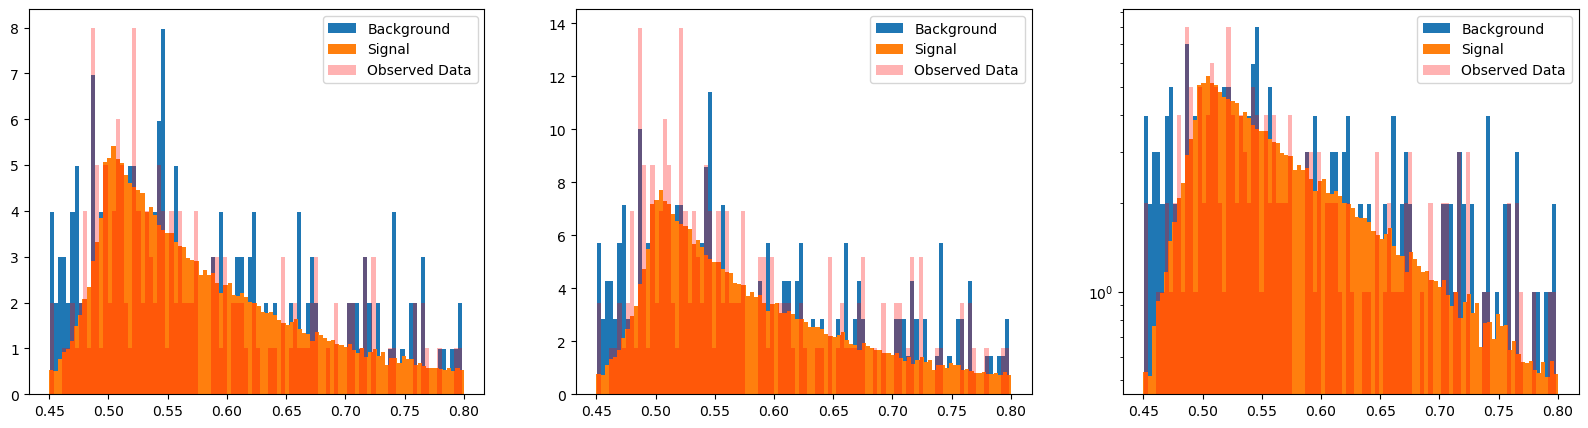

Expected Significance: 5.190611027920224
Observed Significance: 3.6663602914134


In [119]:
#KtDeltaR
plot_lumi(cut_t2_higgs,cut_t2_qcd,cut_t2_highlumi,'KtDeltaR',0,500)
cut_KtDeltaR_higgs, cut_KtDeltaR_qcd, cut_KtDeltaR_highlumi = cut_lumi(cut_t2_higgs,cut_t2_qcd,cut_t2_highlumi,'KtDeltaR',0.45,0.80)
signif1(cut_KtDeltaR_higgs,cut_KtDeltaR_qcd,'KtDeltaR')
lumi_sig(cut_KtDeltaR_higgs,cut_KtDeltaR_qcd, cut_KtDeltaR_highlumi,'KtDeltaR',highlumi)

Significance decreases again.

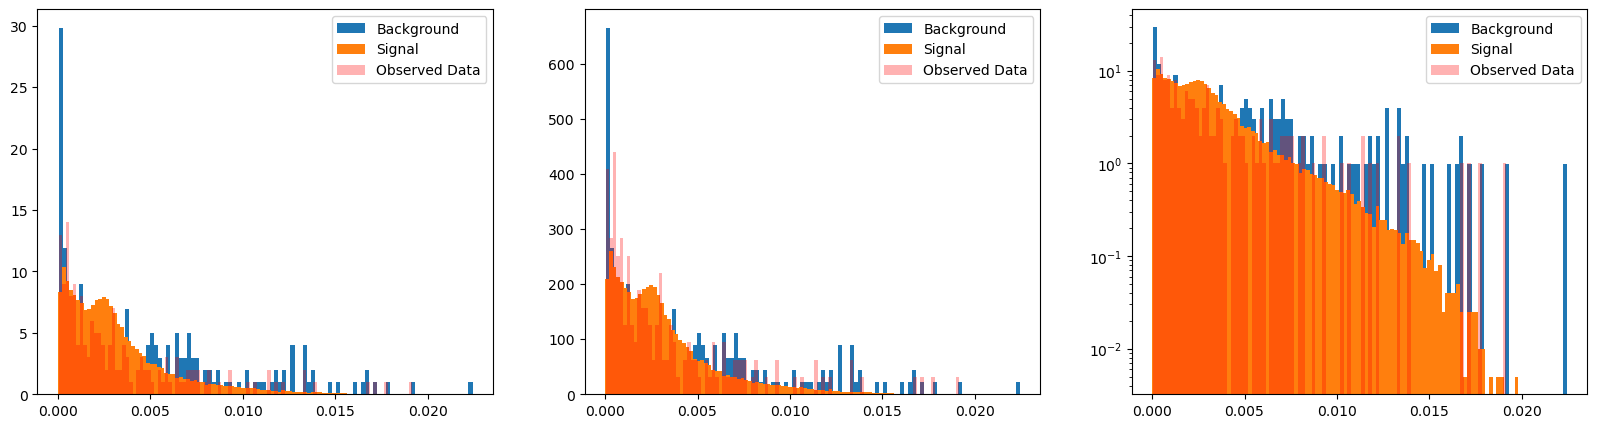

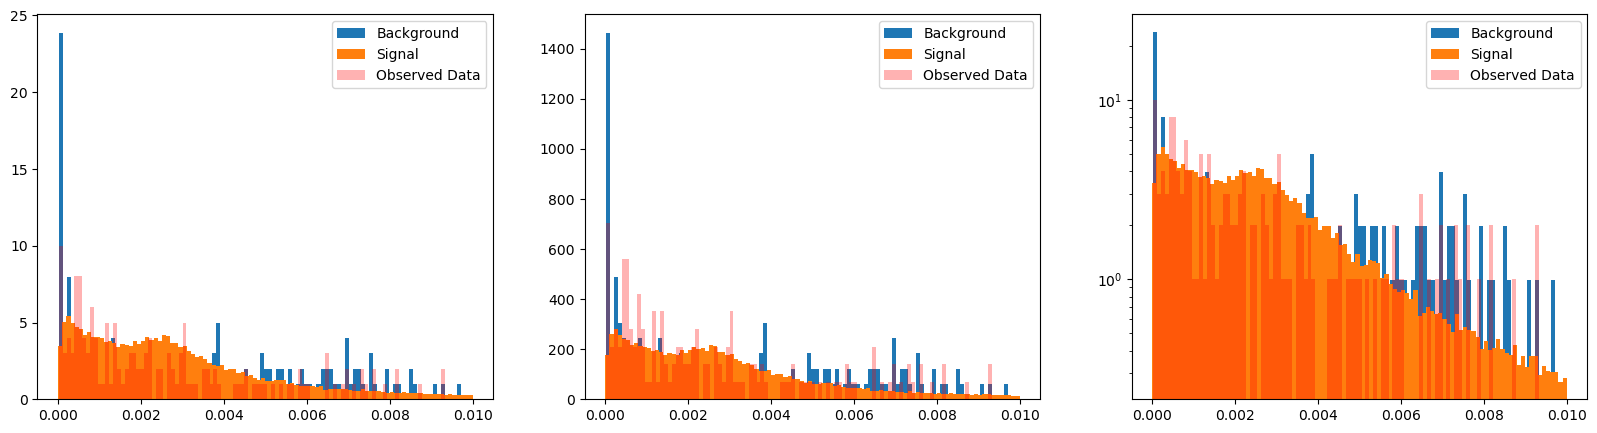

Expected Significance: 5.60350093514365
Observed Significance: 4.0432623413724125


In [120]:
#angularity
plot_lumi(cut_KtDeltaR_higgs,cut_KtDeltaR_qcd,cut_KtDeltaR_highlumi,'angularity',0,500)
cut_angle_higgs, cut_angle_qcd, cut_angle_highlumi = cut_lumi(cut_KtDeltaR_higgs,cut_KtDeltaR_qcd,cut_KtDeltaR_highlumi,'angularity',0,0.01)
signif1(cut_angle_higgs,cut_angle_qcd,'angularity')
lumi_sig(cut_angle_higgs,cut_angle_qcd, cut_angle_highlumi,'angularity',highlumi)

Observed significance increases again

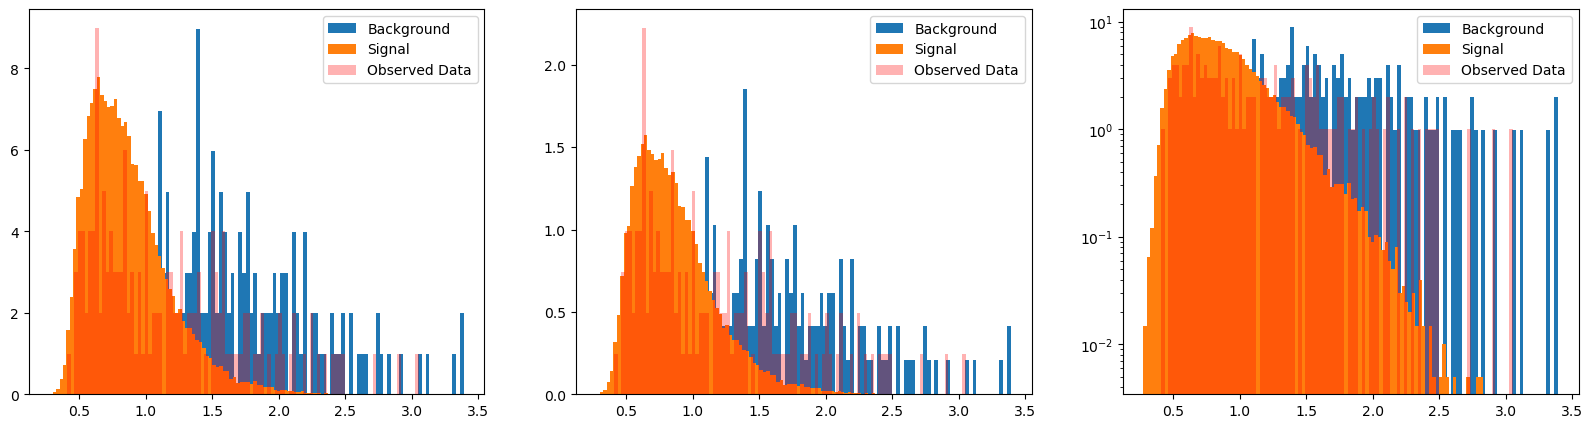

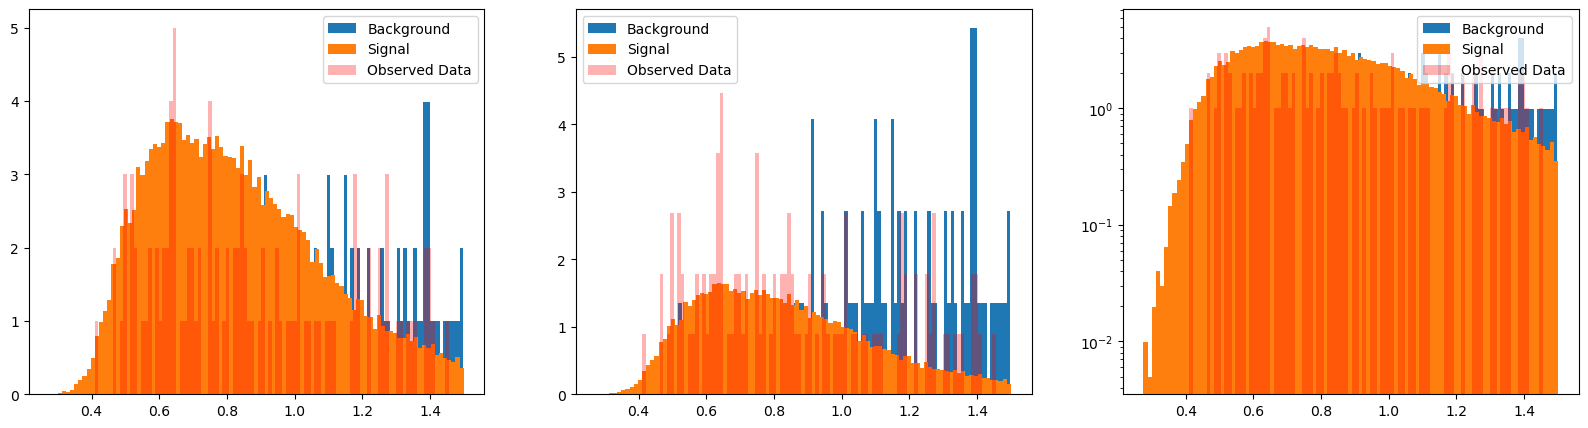

Expected Significance: 8.587508094837364
Observed Significance: 5.275155863120274


In [121]:
#d2
plot_lumi(cut_angle_higgs,cut_angle_qcd,cut_angle_highlumi,'d2',0,500)
cut_d2_higgs, cut_d2_qcd, cut_d2_highlumi = cut_lumi(cut_angle_higgs,cut_angle_qcd,cut_angle_highlumi,'d2',0,1.5)
signif1(cut_d2_higgs,cut_d2_qcd,'d2')
lumi_sig(cut_d2_higgs,cut_d2_qcd, cut_d2_highlumi,'d2',highlumi)

### Low Luminosity Data

In [122]:
lowlumi = pandas.read_hdf('data_lowLumi_pt_250_500.h5')
lowlumi.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

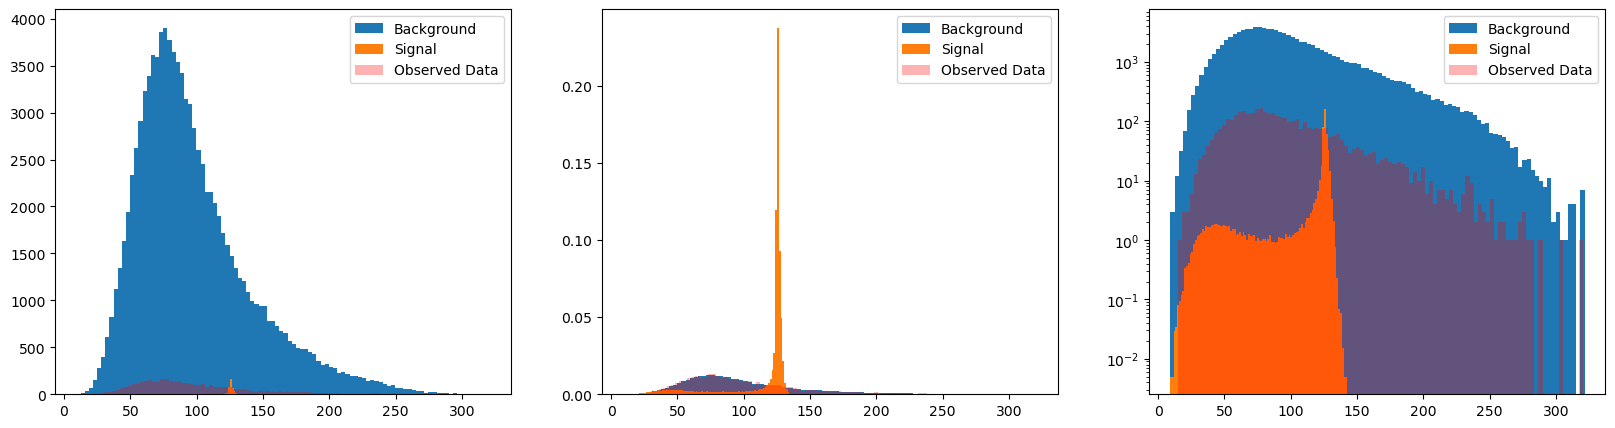

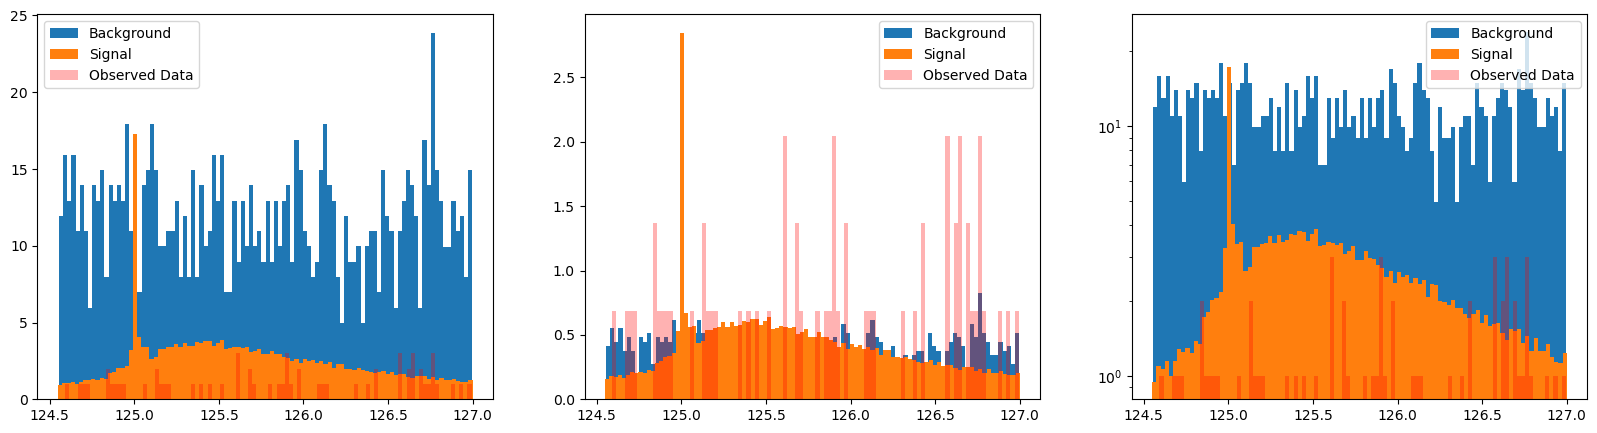

Expected Significance: 3.1065303151335293
Observed Significance: 2.755094994765747


In [127]:
plot_lumi(sample_dict,background_dict,lowlumi,'mass',0,500)
cut_mass_higgs, cut_mass_qcd, cut_mass_lowlumi = cut_lumi(sample_dict,background_dict,lowlumi,'mass',124.55,127)
signif1(cut_mass_higgs,cut_mass_qcd,'mass')
lumi_sig(cut_mass_higgs,cut_mass_qcd, cut_mass_lowlumi,'mass',lowlumi)

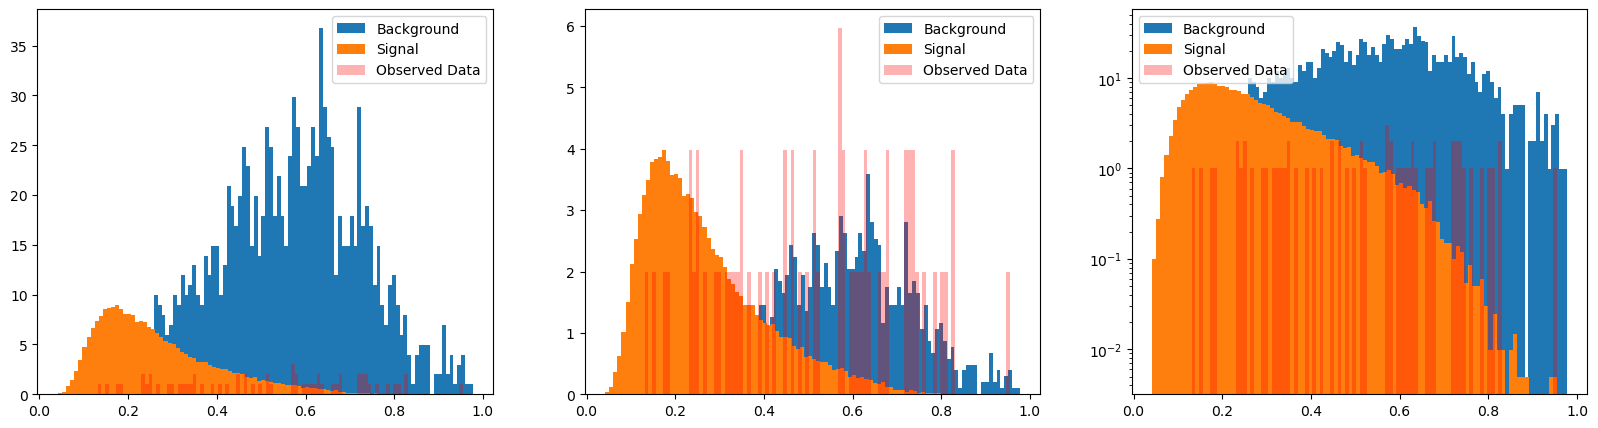

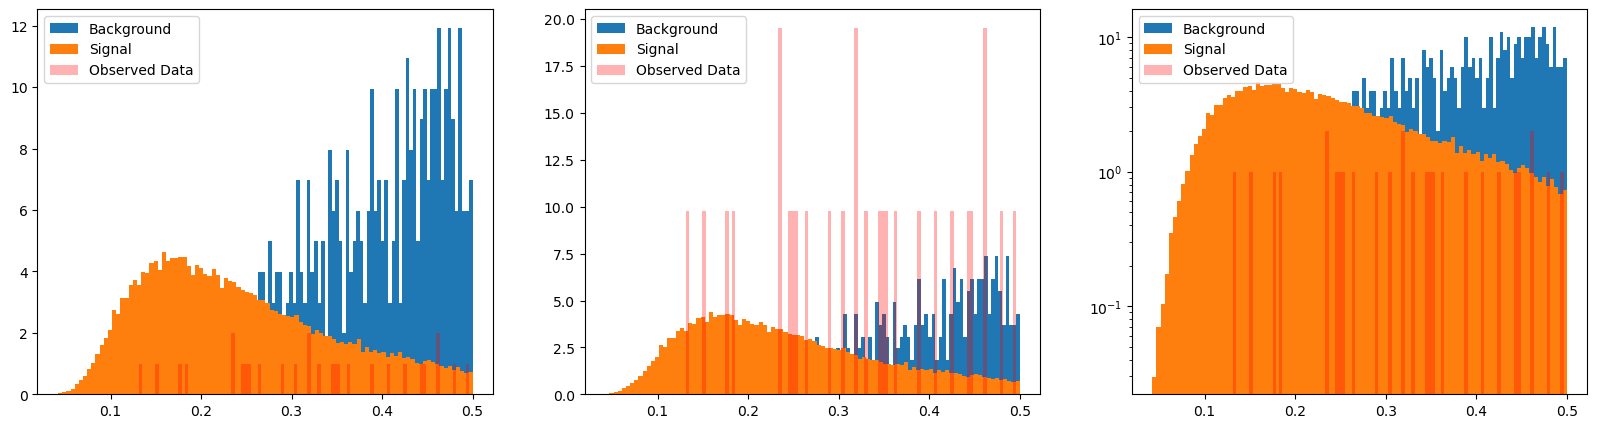

Expected Significance: 4.584010789439429
Observed Significance: 3.8647846086183946


In [128]:
#t21
plot_lumi(cut_mass_higgs,cut_mass_qcd,cut_mass_lowlumi,'t21',0,500)
cut_t21_higgs, cut_t21_qcd, cut_t21_lowlumi = cut_lumi(cut_mass_higgs,cut_mass_qcd,cut_mass_lowlumi,'t21',0,0.50)
signif1(cut_t21_higgs,cut_t21_qcd,'t21')
lumi_sig(cut_t21_higgs,cut_t21_qcd, cut_t21_lowlumi,'t21',lowlumi)

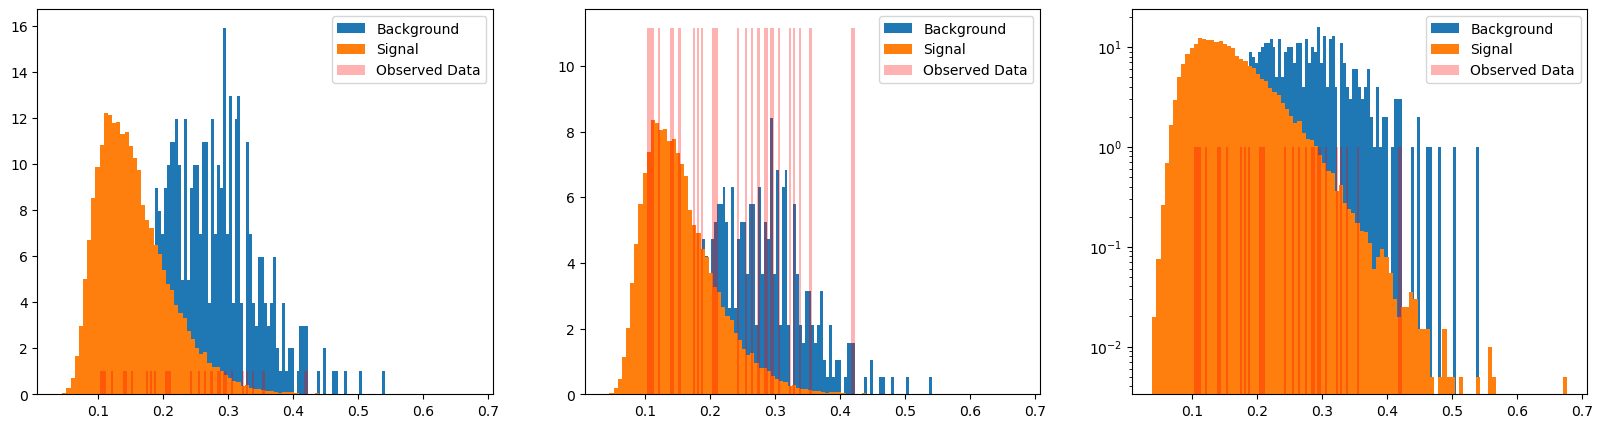

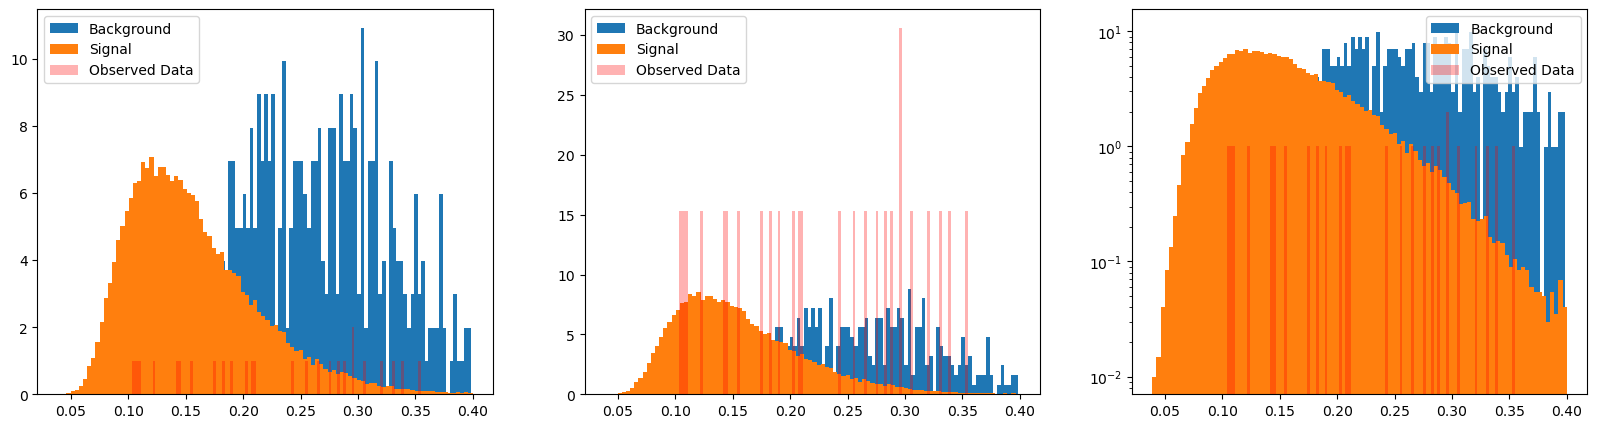

Expected Significance: 4.8262036738161065
Observed Significance: 4.083910892857353


In [129]:
#t3
plot_lumi(cut_t21_higgs,cut_t21_qcd,cut_t21_lowlumi,'t3',0,500)
cut_t3_higgs, cut_t3_qcd, cut_t3_lowlumi = cut_lumi(cut_t21_higgs,cut_t21_qcd,cut_t21_lowlumi,'t3',0,0.40)
signif1(cut_t3_higgs,cut_t3_qcd,'t3')
lumi_sig(cut_t3_higgs,cut_t3_qcd, cut_t3_lowlumi,'t3',lowlumi)

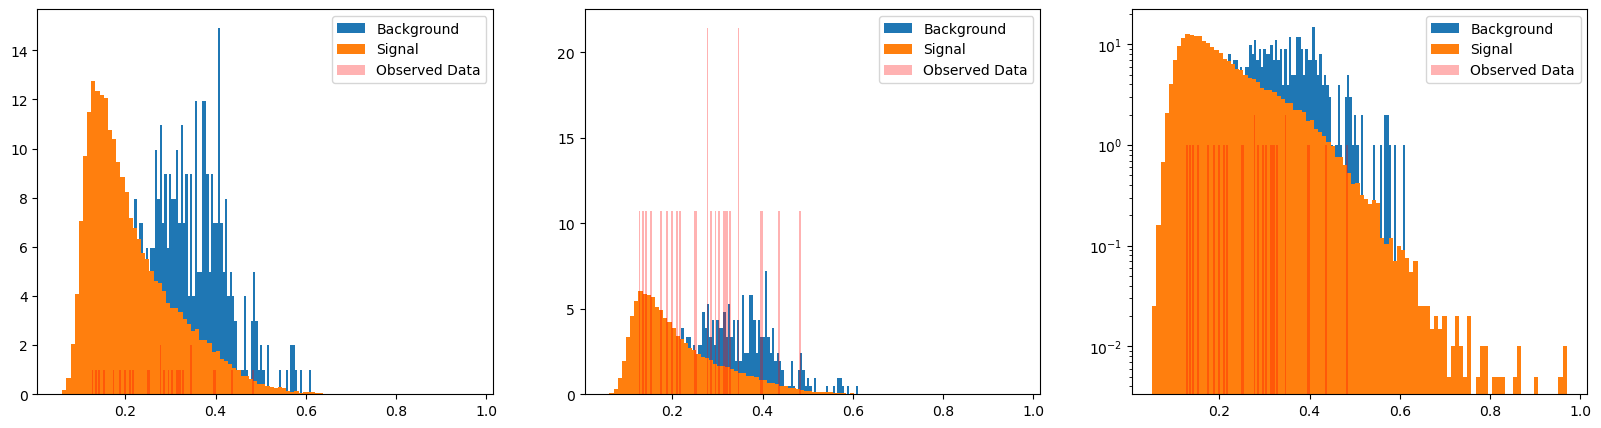

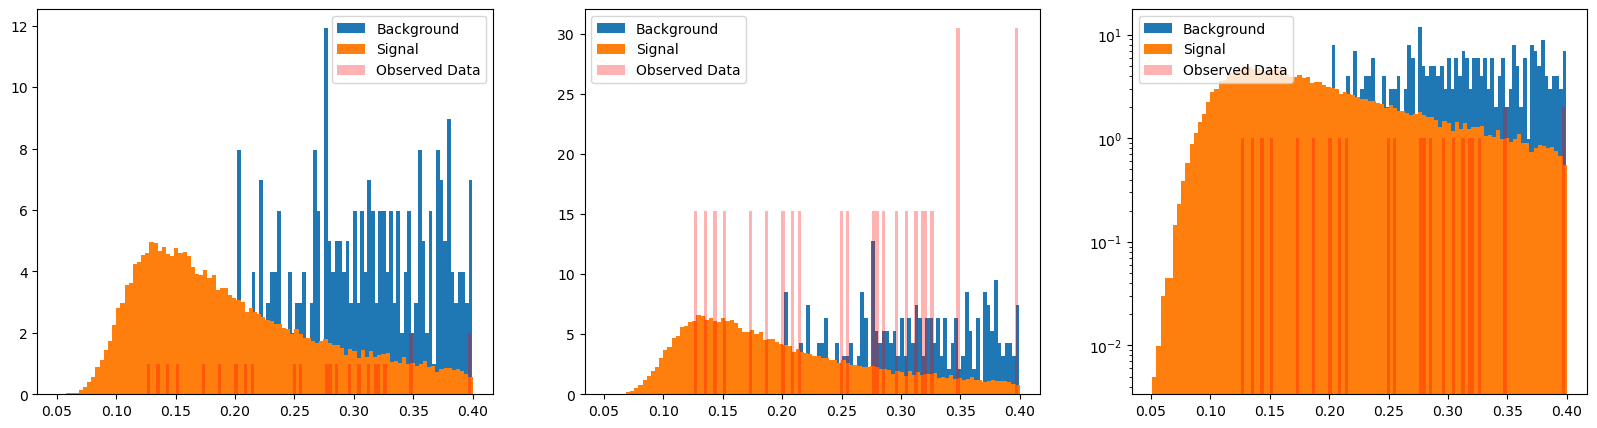

Expected Significance: 5.023933141212832
Observed Significance: 3.87734437977314


In [130]:
#t2
plot_lumi(cut_t3_higgs,cut_t3_qcd,cut_t3_lowlumi,'t2',0,500)
cut_t2_higgs, cut_t2_qcd, cut_t2_lowlumi = cut_lumi(cut_t3_higgs,cut_t3_qcd,cut_t3_lowlumi,'t2',0,0.40)
signif1(cut_t2_higgs,cut_t2_qcd,'t2')
lumi_sig(cut_t2_higgs,cut_t2_qcd, cut_t2_lowlumi,'t2',lowlumi)

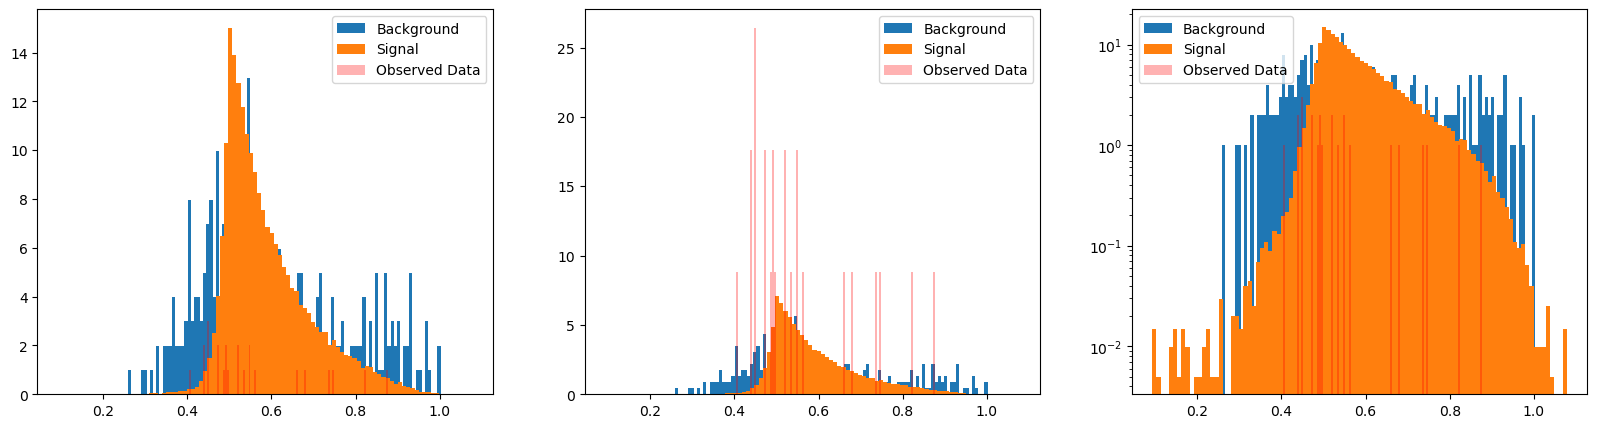

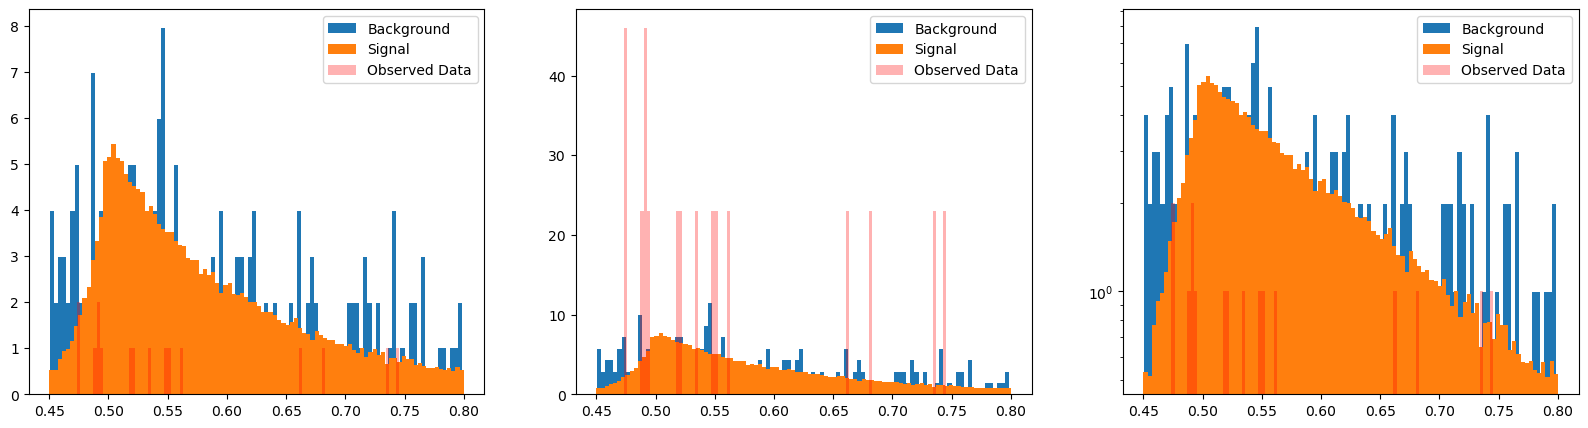

Expected Significance: 5.190611027920224
Observed Significance: 3.7460446983586144


In [131]:
#KtDeltaR
plot_lumi(cut_t2_higgs,cut_t2_qcd,cut_t2_lowlumi,'KtDeltaR',0,500)
cut_KtDeltaR_higgs, cut_KtDeltaR_qcd, cut_KtDeltaR_lowlumi = cut_lumi(cut_t2_higgs,cut_t2_qcd,cut_t2_lowlumi,'KtDeltaR',0.45,0.80)
signif1(cut_KtDeltaR_higgs,cut_KtDeltaR_qcd,'KtDeltaR')
lumi_sig(cut_KtDeltaR_higgs,cut_KtDeltaR_qcd, cut_KtDeltaR_lowlumi,'KtDeltaR',lowlumi)

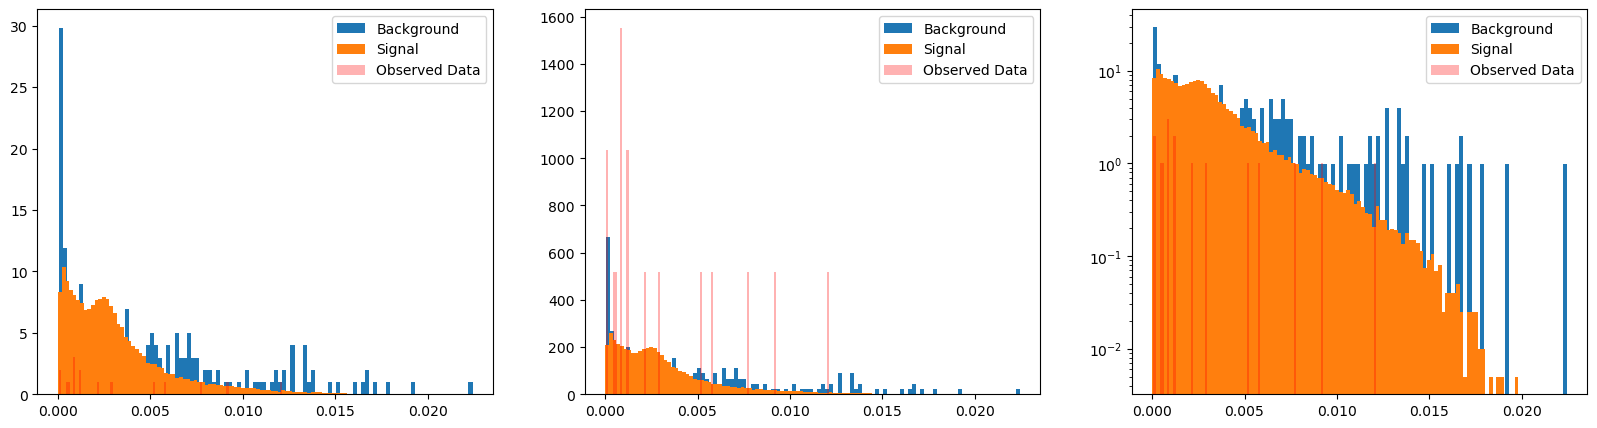

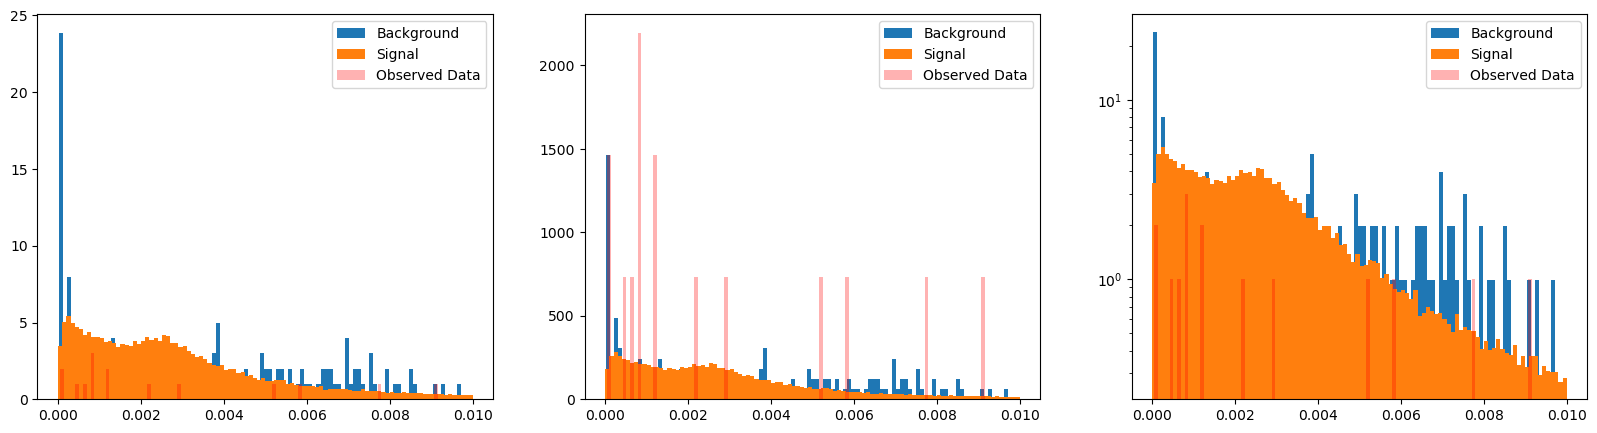

Expected Significance: 5.60350093514365
Observed Significance: 4.123136721441791


In [132]:
#angularity
plot_lumi(cut_KtDeltaR_higgs,cut_KtDeltaR_qcd,cut_KtDeltaR_lowlumi,'angularity',0,500)
cut_angle_higgs, cut_angle_qcd, cut_angle_lowlumi = cut_lumi(cut_KtDeltaR_higgs,cut_KtDeltaR_qcd,cut_KtDeltaR_lowlumi,'angularity',0,0.01)
signif1(cut_angle_higgs,cut_angle_qcd,'angularity')
lumi_sig(cut_angle_higgs,cut_angle_qcd, cut_angle_lowlumi,'angularity',lowlumi)

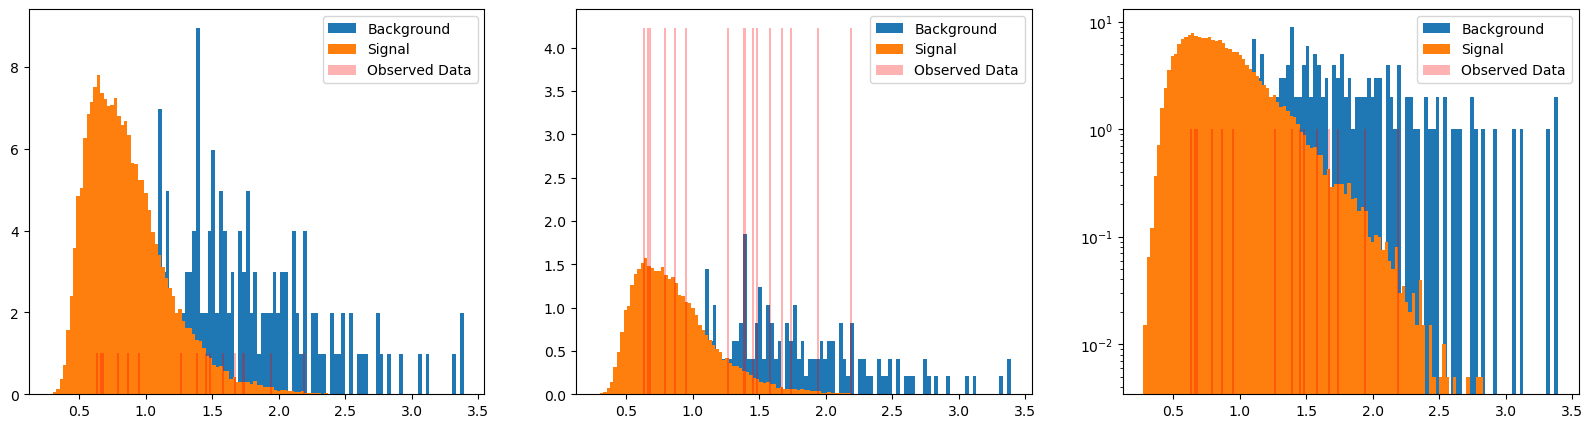

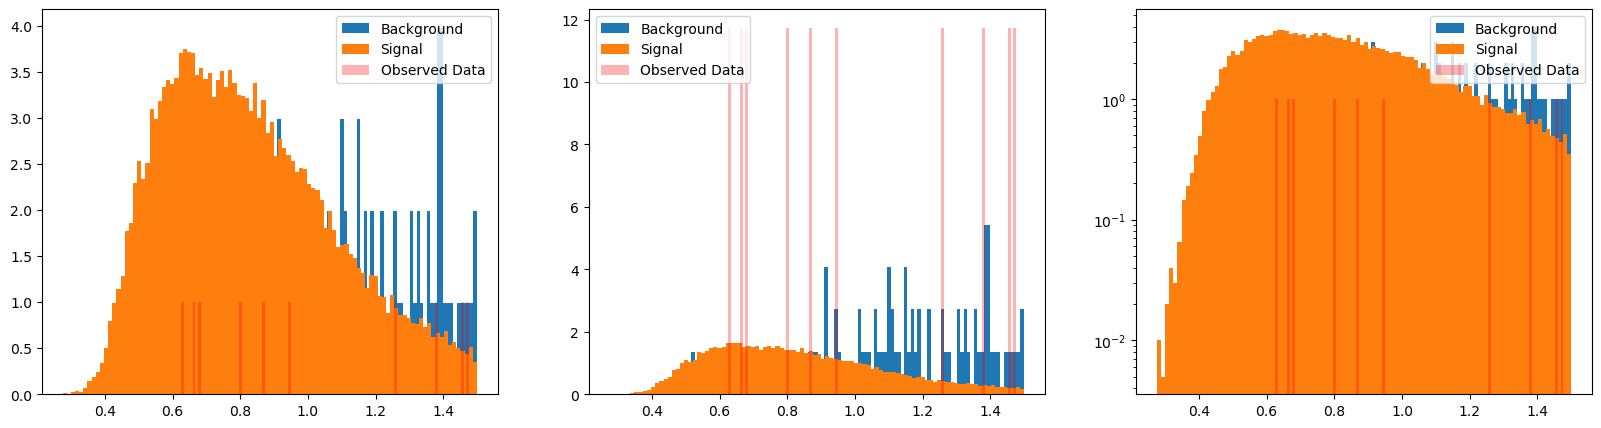

Expected Significance: 8.587508094837364
Observed Significance: 5.117287951674127


In [133]:
#d2
plot_lumi(cut_angle_higgs,cut_angle_qcd,cut_angle_lowlumi,'d2',0,500)
cut_d2_higgs, cut_d2_qcd, cut_d2_lowlumi = cut_lumi(cut_angle_higgs,cut_angle_qcd,cut_angle_lowlumi,'d2',0,1.5)
signif1(cut_d2_higgs,cut_d2_qcd,'d2')
lumi_sig(cut_d2_higgs,cut_d2_qcd, cut_d2_lowlumi,'d2',lowlumi)

### 95% Confidence Level of signal yields

In [135]:
# expected 95% confidence level upper limit
print(np.percentile(sample_dict,95))
print(np.percentile(background_dict,95))

# observed 95% confidence level upper limit
print(np.percentile(lowlumi,95))

440.11661977740147
430.2609424749776
431.04281115017505


In [ ]:
expect = np.quantile(np.array(higgs_table['mass'])[np.where((higgs_table['mass']<133)&(higgs_table['mass']>120)&(higgs_table['pt']<492)&(higgs_table['t3']<0.3)&(higgs_table['t21']<0.2))],[.5,.95])
print('My expected 95% confidence upper bound on the Higgs boson mass is {0}'.format(expect[1]))

In [ ]:
expected = np.quantile(np.array())